## 1. Introducción

El presente proyecto se basa en tratar de predecir aquellos contratos que serán cancelados y no continuarán con la compañía Interconnect. Para esto, se cuenta con datos previamente analizados y con respuestas obtenidas con respecto a algunas dudas que surgieron en el análisis. Se seguirá el plan de trabajo propuesto, transformando los datos para utilzarlos en la creación y entrenamiento de modelos. Posteriormente se probarán los modelos para obtener un modelo seleccionado con hiperparámetros específicos. Finalmente, en el informe de solución, se presenta el modelo seleccionado en adición con la predicción de los clientes nuevos que no fueron considerados en el análisis debido a que no han realizado al menos un solo pago de su contrato.

In [195]:
#importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder as le
from sklearn.preprocessing import StandardScaler as ss
from sklearn.utils import shuffle as sh
from sklearn.model_selection import train_test_split as tts 

from sklearn.dummy import DummyClassifier as dc 
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.linear_model import LogisticRegression as lr
from catboost import CatBoostClassifier as cbc
from sklearn.metrics import roc_auc_score as ras
from sklearn.metrics import roc_curve as roc
from sklearn.metrics import accuracy_score as acs

## 2. Conversión de DataFrames originales

In [196]:
#Leemos los datos
contract=pd.read_csv('D:/Datos_Perfil/OneDrive - PETROLEOS MEXICANOS/EJMRL/TripleTen/17 - Proyecto Final/contract_worked.csv')
internet=pd.read_csv('D:/Datos_Perfil/OneDrive - PETROLEOS MEXICANOS/EJMRL/TripleTen/17 - Proyecto Final/internet.csv')
personal=pd.read_csv('D:/Datos_Perfil/OneDrive - PETROLEOS MEXICANOS/EJMRL/TripleTen/17 - Proyecto Final/personal.csv')
phone=pd.read_csv('D:/Datos_Perfil/OneDrive - PETROLEOS MEXICANOS/EJMRL/TripleTen/17 - Proyecto Final/phone.csv')

In [197]:
#Convertimos el df phone
encoder=le()
mlines=pd.DataFrame(encoder.fit_transform(phone['MultipleLines']))
phone['MultipleLines']=mlines
phone

,customerID,MultipleLines
0,5575-GNVDE,0
1,3668-QPYBK,0
2,9237-HQITU,0
3,9305-CDSKC,1
4,1452-KIOVK,1
...,...,...
6356,2569-WGERO,0
6357,6840-RESVB,1
6358,2234-XADUH,1
6359,8361-LTMKD,1


In [198]:
#Convertimos el df personal
encoder=le()
partner=pd.DataFrame(encoder.fit_transform(personal['Partner']))
dependents=pd.DataFrame(encoder.fit_transform(personal['Dependents']))
gender=pd.get_dummies(personal['gender'],drop_first=True,dtype=int)
personal['Partner']=partner
personal['Dependents']=dependents
personal['gender(0=F,1=M)']=gender
personal=personal.drop('gender',axis=1)
personal

,customerID,SeniorCitizen,Partner,Dependents,"gender(0=F,1=M)"
0,7590-VHVEG,0,1,0,0
1,5575-GNVDE,0,0,0,1
2,3668-QPYBK,0,0,0,1
3,7795-CFOCW,0,0,0,1
4,9237-HQITU,0,0,0,0
...,...,...,...,...,...
7038,6840-RESVB,0,1,1,1
7039,2234-XADUH,0,1,1,0
7040,4801-JZAZL,0,1,1,0
7041,8361-LTMKD,1,1,0,1


In [199]:
#Convertimos el df internet
encoder=le()
cols=internet.columns[2:8]
for i in cols:
    new_val=pd.DataFrame(encoder.fit_transform(internet[i]))
    internet[i]=new_val
service=pd.get_dummies(internet['InternetService'],drop_first=True,dtype=int)
internet['IntServ(0=DSL,1=FO)']=service
internet=internet.drop('InternetService',axis=1)
internet

,customerID,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,"IntServ(0=DSL,1=FO)"
0,7590-VHVEG,0,1,0,0,0,0,0
1,5575-GNVDE,1,0,1,0,0,0,0
2,3668-QPYBK,1,1,0,0,0,0,0
3,7795-CFOCW,1,0,1,1,0,0,0
4,9237-HQITU,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,1,0,1,1,1,1,0
5513,2234-XADUH,0,1,1,0,1,1,1
5514,4801-JZAZL,1,0,0,0,0,0,0
5515,8361-LTMKD,0,0,0,0,0,0,1


In [200]:
#Convertimos el df contract y adicionamos características al df
#Para la columna type(0-MonthToMonth,1-OneYear,2-TwoYear). Para la columna PaymenthMethod(0-BankTransfer,1-CreditCard,2-ElectronicCheck,3-MailedCheck)
encoder=le()
cols=contract.columns[3:6]
for i in cols:
    new_val=pd.DataFrame(encoder.fit_transform(contract[i]))
    contract[i]=new_val
contract['BeginDate']=pd.to_datetime(contract['BeginDate'],format='%Y-%m-%d')
contract['MonthsWithService']=contract['TotalCharges']/contract['MonthlyCharges']
contract=contract.drop('BeginDate',axis=1) #Sustituimos con la caracteristica creada, el aproximado de tiempo que ha estado contratado el servicio
contract

,customerID,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MonthsWithService
0,7590-VHVEG,No,0,1,2,29.85,29.85,1.000000
1,5575-GNVDE,No,1,0,3,56.95,1889.50,33.178227
2,3668-QPYBK,2019-12-01 00:00:00,0,1,3,53.85,108.15,2.008357
3,7795-CFOCW,No,1,0,0,42.30,1840.75,43.516548
4,9237-HQITU,2019-11-01 00:00:00,0,1,2,70.70,151.65,2.144979
...,...,...,...,...,...,...,...,...
7027,6840-RESVB,No,1,1,3,84.80,1990.50,23.472877
7028,2234-XADUH,No,1,1,1,103.20,7362.90,71.345930
7029,4801-JZAZL,No,0,1,2,29.60,346.45,11.704392
7030,8361-LTMKD,2019-11-01 00:00:00,0,1,3,74.40,306.60,4.120968


## 3. Creación de DataFrame Final

In [201]:
#Unimos los primeros dos dfs
df_work=contract.merge(internet,on='customerID',how='outer')
df_work

,customerID,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MonthsWithService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,"IntServ(0=DSL,1=FO)"
0,7590-VHVEG,No,0.0,1.0,2.0,29.85,29.85,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,5575-GNVDE,No,1.0,0.0,3.0,56.95,1889.50,33.178227,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3668-QPYBK,2019-12-01 00:00:00,0.0,1.0,3.0,53.85,108.15,2.008357,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,7795-CFOCW,No,1.0,0.0,0.0,42.30,1840.75,43.516548,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4,9237-HQITU,2019-11-01 00:00:00,0.0,1.0,2.0,70.70,151.65,2.144979,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7032,4472-LVYGI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,1.0,1.0,0.0,0.0
7033,5709-LVOEQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,1.0,1.0,0.0
7034,1371-DWPAZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,0.0,0.0
7035,4075-WKNIU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1.0,0.0,0.0


In [202]:
#Adicionamos el tercer df
df_work=df_work.merge(personal,on='customerID',how='outer')
df_work

,customerID,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MonthsWithService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,"IntServ(0=DSL,1=FO)",SeniorCitizen,Partner,Dependents,"gender(0=F,1=M)"
0,7590-VHVEG,No,0.0,1.0,2.0,29.85,29.85,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
1,5575-GNVDE,No,1.0,0.0,3.0,56.95,1889.50,33.178227,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,1
2,3668-QPYBK,2019-12-01 00:00:00,0.0,1.0,3.0,53.85,108.15,2.008357,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
3,7795-CFOCW,No,1.0,0.0,0.0,42.30,1840.75,43.516548,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0,0,0,1
4,9237-HQITU,2019-11-01 00:00:00,0.0,1.0,2.0,70.70,151.65,2.144979,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,4367-NUYAO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,1
7039,7644-OMVMY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,1
7040,3213-VVOLG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,1
7041,2520-SGTTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0


In [203]:
#Agregamos el 4to df
df_work=df_work.merge(phone,on='customerID',how='outer')
df_work

,customerID,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MonthsWithService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,"IntServ(0=DSL,1=FO)",SeniorCitizen,Partner,Dependents,"gender(0=F,1=M)",MultipleLines
0,7590-VHVEG,No,0.0,1.0,2.0,29.85,29.85,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,NaN
1,5575-GNVDE,No,1.0,0.0,3.0,56.95,1889.50,33.178227,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,1,0.0
2,3668-QPYBK,2019-12-01 00:00:00,0.0,1.0,3.0,53.85,108.15,2.008357,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0.0
3,7795-CFOCW,No,1.0,0.0,0.0,42.30,1840.75,43.516548,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0,0,0,1,NaN
4,9237-HQITU,2019-11-01 00:00:00,0.0,1.0,2.0,70.70,151.65,2.144979,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,4367-NUYAO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,1,1.0
7039,7644-OMVMY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,1,0.0
7040,3213-VVOLG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,1,1.0
7041,2520-SGTTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,0.0


In [204]:
#Debido a que se hicieron presunciones en el df de contract sobre ciertas observaciones, se hace un filtro para mantener la consistencia
df_work=df_work.query("customerID in @contract.customerID")
df_work

,customerID,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MonthsWithService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,"IntServ(0=DSL,1=FO)",SeniorCitizen,Partner,Dependents,"gender(0=F,1=M)",MultipleLines
0,7590-VHVEG,No,0.0,1.0,2.0,29.85,29.85,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,NaN
1,5575-GNVDE,No,1.0,0.0,3.0,56.95,1889.50,33.178227,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,1,0.0
2,3668-QPYBK,2019-12-01 00:00:00,0.0,1.0,3.0,53.85,108.15,2.008357,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0.0
3,7795-CFOCW,No,1.0,0.0,0.0,42.30,1840.75,43.516548,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0,0,0,1,NaN
4,9237-HQITU,2019-11-01 00:00:00,0.0,1.0,2.0,70.70,151.65,2.144979,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,No,1.0,1.0,3.0,84.80,1990.50,23.472877,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0,1,1,1,1.0
7028,2234-XADUH,No,1.0,1.0,1.0,103.20,7362.90,71.345930,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0,1,1,0,1.0
7029,4801-JZAZL,No,0.0,1.0,2.0,29.60,346.45,11.704392,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,0,NaN
7030,8361-LTMKD,2019-11-01 00:00:00,0.0,1.0,3.0,74.40,306.60,4.120968,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,0,1,1.0


In [205]:
#Modificamos la columna objetivo para que tenga los valores necesarios para ser considerada
objective=[]
for i in df_work['EndDate']:
    if i == 'No':
        objective.append(0)
    else:
        objective.append(1)
df_work['EndDate']=objective
df_work

C:\Users\555081\AppData\Local\Temp\ipykernel_11200\3354292175.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_work['EndDate']=objective


,customerID,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MonthsWithService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,"IntServ(0=DSL,1=FO)",SeniorCitizen,Partner,Dependents,"gender(0=F,1=M)",MultipleLines
0,7590-VHVEG,0,0.0,1.0,2.0,29.85,29.85,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,NaN
1,5575-GNVDE,0,1.0,0.0,3.0,56.95,1889.50,33.178227,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,1,0.0
2,3668-QPYBK,1,0.0,1.0,3.0,53.85,108.15,2.008357,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0.0
3,7795-CFOCW,0,1.0,0.0,0.0,42.30,1840.75,43.516548,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0,0,0,1,NaN
4,9237-HQITU,1,0.0,1.0,2.0,70.70,151.65,2.144979,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,0,1.0,1.0,3.0,84.80,1990.50,23.472877,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0,1,1,1,1.0
7028,2234-XADUH,0,1.0,1.0,1.0,103.20,7362.90,71.345930,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0,1,1,0,1.0
7029,4801-JZAZL,0,0.0,1.0,2.0,29.60,346.45,11.704392,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,0,NaN
7030,8361-LTMKD,1,0.0,1.0,3.0,74.40,306.60,4.120968,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,0,1,1.0


In [206]:
#Corroboramos la información del df de trabajo
df_work.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customerID           7032 non-null   object 
 1   EndDate              7032 non-null   int64  
 2   Type                 7032 non-null   float64
 3   PaperlessBilling     7032 non-null   float64
 4   PaymentMethod        7032 non-null   float64
 5   MonthlyCharges       7032 non-null   float64
 6   TotalCharges         7032 non-null   float64
 7   MonthsWithService    7032 non-null   float64
 8   OnlineSecurity       5512 non-null   float64
 9   OnlineBackup         5512 non-null   float64
 10  DeviceProtection     5512 non-null   float64
 11  TechSupport          5512 non-null   float64
 12  StreamingTV          5512 non-null   float64
 13  StreamingMovies      5512 non-null   float64
 14  IntServ(0=DSL,1=FO)  5512 non-null   float64
 15  SeniorCitizen        7032 non-null   int64 

In [207]:
#Debido a la unión de df con diferente cantidad de observaciones, se cuenta con valores ausentes, por lo que se toma la consideración de que dichos
#valores ausentes sean 0, ya que al no existir la información del cliente, considereamos que no aplica para el mismo
df_work=df_work.fillna(0)
df_work

,customerID,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MonthsWithService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,"IntServ(0=DSL,1=FO)",SeniorCitizen,Partner,Dependents,"gender(0=F,1=M)",MultipleLines
0,7590-VHVEG,0,0.0,1.0,2.0,29.85,29.85,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0.0
1,5575-GNVDE,0,1.0,0.0,3.0,56.95,1889.50,33.178227,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,1,0.0
2,3668-QPYBK,1,0.0,1.0,3.0,53.85,108.15,2.008357,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0.0
3,7795-CFOCW,0,1.0,0.0,0.0,42.30,1840.75,43.516548,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0,0,0,1,0.0
4,9237-HQITU,1,0.0,1.0,2.0,70.70,151.65,2.144979,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,0,1.0,1.0,3.0,84.80,1990.50,23.472877,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0,1,1,1,1.0
7028,2234-XADUH,0,1.0,1.0,1.0,103.20,7362.90,71.345930,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0,1,1,0,1.0
7029,4801-JZAZL,0,0.0,1.0,2.0,29.60,346.45,11.704392,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,0,0.0
7030,8361-LTMKD,1,0.0,1.0,3.0,74.40,306.60,4.120968,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,0,1,1.0


In [208]:
#Corroboramos la información del df de trabajo
df_work.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customerID           7032 non-null   object 
 1   EndDate              7032 non-null   int64  
 2   Type                 7032 non-null   float64
 3   PaperlessBilling     7032 non-null   float64
 4   PaymentMethod        7032 non-null   float64
 5   MonthlyCharges       7032 non-null   float64
 6   TotalCharges         7032 non-null   float64
 7   MonthsWithService    7032 non-null   float64
 8   OnlineSecurity       7032 non-null   float64
 9   OnlineBackup         7032 non-null   float64
 10  DeviceProtection     7032 non-null   float64
 11  TechSupport          7032 non-null   float64
 12  StreamingTV          7032 non-null   float64
 13  StreamingMovies      7032 non-null   float64
 14  IntServ(0=DSL,1=FO)  7032 non-null   float64
 15  SeniorCitizen        7032 non-null   int64 

## 4. Creación y Entrenamiento de Modelos
### 4.1 Definición de Características y Objetivos

In [209]:
#Creamos el df de caracteristicas
features=df_work.drop(['customerID','EndDate'],axis=1)
features

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MonthsWithService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,"IntServ(0=DSL,1=FO)",SeniorCitizen,Partner,Dependents,"gender(0=F,1=M)",MultipleLines
0,0.0,1.0,2.0,29.85,29.85,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0.0
1,1.0,0.0,3.0,56.95,1889.50,33.178227,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,1,0.0
2,0.0,1.0,3.0,53.85,108.15,2.008357,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0.0
3,1.0,0.0,0.0,42.30,1840.75,43.516548,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0,0,0,1,0.0
4,0.0,1.0,2.0,70.70,151.65,2.144979,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,1.0,1.0,3.0,84.80,1990.50,23.472877,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0,1,1,1,1.0
7028,1.0,1.0,1.0,103.20,7362.90,71.345930,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0,1,1,0,1.0
7029,0.0,1.0,2.0,29.60,346.45,11.704392,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,0,0.0
7030,0.0,1.0,3.0,74.40,306.60,4.120968,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,0,1,1.0


In [210]:
#Obtenemos los objetivos
objective=df_work['EndDate']
objective

0       0
1       0
2       1
3       0
4       1
       ..
7027    0
7028    0
7029    0
7030    1
7031    0
Name: EndDate, Length: 7032, dtype: int64

### 4.2 Equilibrio de Clases

In [211]:
#Verificamos el equilibrio de clases
objective.value_counts(normalize=True)

EndDate
0    0.734215
1    0.265785
Name: proportion, dtype: float64

<Axes: title={'center': 'Equilibrio de clases'}, xlabel='Variable Objetivo'>

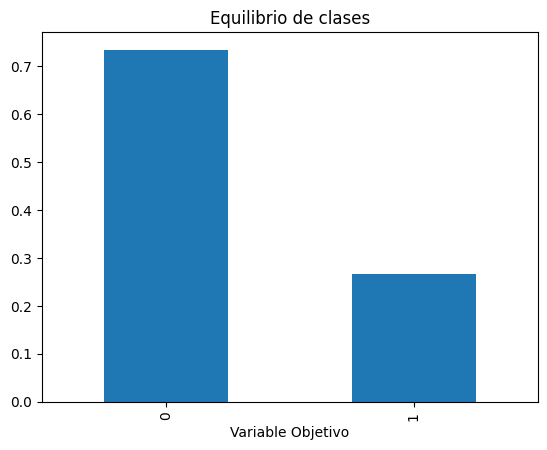

In [212]:
#Graficamos el equilibrio de clases
objective.value_counts(normalize=True).plot(kind='bar',title='Equilibrio de clases',xlabel='Variable Objetivo')

In [213]:
#Creamos una función para corregir desequilibrio de clases con sobremuestreo
def sobremuestreo(feat,targ,multiplo):
    feat_0=feat[targ==0]
    feat_1=feat[targ==1]
    targ_0=targ[targ==0]
    targ_1=targ[targ==1]
    feat_sm=pd.concat([feat_0]+[feat_1]*multiplo)
    targ_sm=pd.concat([targ_0]+[targ_1]*multiplo)
    feat_sm,targ_sm=sh(feat_sm,targ_sm,random_state=21042407)
    return feat_sm, targ_sm

In [214]:
#Aplicamos la función creada para corregir el desequilibrio
feats,targs=sobremuestreo(features,objective,3)

In [215]:
#Verificamos el equilibrio de clases
targs.value_counts(normalize=True)

EndDate
1    0.520613
0    0.479387
Name: proportion, dtype: float64

<Axes: title={'center': 'Equilibrio de clases'}, xlabel='Variable Objetivo'>

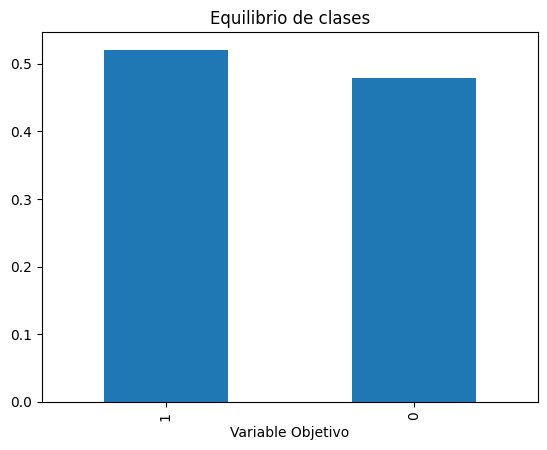

In [216]:
#Graficamos el equilibrio de clases
targs.value_counts(normalize=True).plot(kind='bar',title='Equilibrio de clases',xlabel='Variable Objetivo')

In [217]:
#Vamos a intentar corregir el equilibrio de clases, ahora con una función de submuestreo ya que solo el sobremuestreo no fue suficiente
def submuestreo(features,target,frac):
	feat_zero=features[target==0]
	feat_ones=features[target==1]
	targ_zero=target[target==0]
	targ_ones=target[target==1]
	feat_sb=pd.concat([feat_ones.sample(frac=frac,random_state=21042407)]+[feat_zero])
	targ_sb=pd.concat([targ_ones.sample(frac=frac,random_state=21042407)]+[targ_zero])
	feat_sb,targ_sb=sh(feat_sb,targ_sb,random_state=21042407)
	return feat_sb,targ_sb

In [218]:
#Aplicamos la función creada
feats,targs=submuestreo(feats,targs,0.92)

In [219]:
#Verificamos el equilibrio de clases
targs.value_counts(normalize=True)

EndDate
0    0.500242
1    0.499758
Name: proportion, dtype: float64

<Axes: title={'center': 'Equilibrio de clases'}, xlabel='Variable Objetivo'>

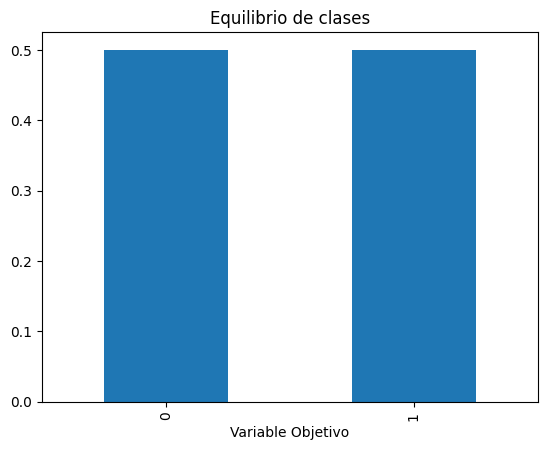

In [220]:
#Graficamos el equilibrio de clases
targs.value_counts(normalize=True).plot(kind='bar',title='Equilibrio de clases',xlabel='Variable Objetivo')

In [221]:
#Corroboramos las características
feats

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MonthsWithService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,"IntServ(0=DSL,1=FO)",SeniorCitizen,Partner,Dependents,"gender(0=F,1=M)",MultipleLines
4656,0.0,0.0,1.0,74.90,147.15,1.964619,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,1.0
5279,0.0,1.0,2.0,79.65,79.65,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,0,0,0,0.0
1503,0.0,1.0,0.0,88.45,2130.55,24.087620,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1,1,1,0,0.0
3818,0.0,1.0,3.0,55.30,238.50,4.312839,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,1,0.0
1668,0.0,1.0,0.0,113.60,4594.95,40.448504,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4341,0.0,1.0,3.0,19.10,19.10,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0
6323,2.0,1.0,0.0,105.25,7173.15,68.153444,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0,1,1,1,0.0
3451,0.0,1.0,3.0,19.50,19.50,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0
3845,0.0,1.0,0.0,19.65,19.65,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0.0


In [222]:
#Corroboramos los objetivos
targs

4656    1
5279    1
1503    0
3818    0
1668    1
       ..
4341    1
6323    0
3451    0
3845    0
2356    1
Name: EndDate, Length: 10321, dtype: int64

### 4.3 Segmentación de Conjuntos

In [223]:
#Definimos el conjunto de datos de entrenamiento
f_train,f_vt,t_train,t_vt=tts(feats,targs,train_size=0.6,random_state=21042407)
print(f_train.shape)
print(t_train.shape)

(6192, 18)
(6192,)


In [224]:
#Definimos los conjuntos de datos de validación y prueba
f_valid,f_test,t_valid,t_test=tts(f_vt,t_vt,test_size=0.5,random_state=21042407)
print(f_valid.shape)
print(t_valid.shape)
print(f_test.shape)
print(t_test.shape)

(2064, 18)
(2064,)
(2065, 18)
(2065,)


### 4.4 Escalado de Características

In [225]:
#Realizamos el escalado de características para los tres conjuntos de datos
scal=ss()
scal.fit(f_train)
f_train_s=pd.DataFrame(scal.transform(f_train),columns=f_train.columns)
f_valid_s=pd.DataFrame(scal.transform(f_valid),columns=f_valid.columns)
f_test_s=pd.DataFrame(scal.transform(f_test),columns=f_test.columns)

In [226]:
#Corroboramos para el conjunto de entrenamiento
f_train_s

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MonthsWithService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,"IntServ(0=DSL,1=FO)",SeniorCitizen,Partner,Dependents,"gender(0=F,1=M)",MultipleLines
0,1.961171,-1.338546,-1.613715,0.653188,1.960294,1.890535,-0.572377,1.447757,1.435549,1.717259,1.225899,1.220962,-1.035849,-0.476816,-0.892966,-0.589784,-1.014970,1.151551
1,-0.663331,0.747080,-0.628687,1.401492,1.162534,0.612131,1.747099,1.447757,-0.696598,1.717259,1.225899,1.220962,0.965392,2.097244,-0.892966,-0.589784,-1.014970,-0.868394
2,0.648920,0.747080,-0.628687,-0.258320,0.385519,0.838546,1.747099,-0.690724,1.435549,1.717259,-0.815728,-0.819026,-1.035849,-0.476816,-0.892966,-0.589784,-1.014970,-0.868394
3,-0.663331,0.747080,-1.613715,0.788612,-0.063922,-0.277537,-0.572377,-0.690724,-0.696598,1.717259,1.225899,-0.819026,0.965392,2.097244,-0.892966,-0.589784,0.985251,1.151551
4,1.961171,-1.338546,-0.628687,1.641089,1.296756,0.612447,1.747099,1.447757,1.435549,1.717259,1.225899,1.220962,0.965392,-0.476816,-0.892966,-0.589784,-1.014970,1.151551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6187,-0.663331,-1.338546,0.356341,-0.786126,-0.914408,-1.112534,-0.572377,-0.690724,-0.696598,-0.582323,-0.815728,-0.819026,-1.035849,-0.476816,-0.892966,-0.589784,-1.014970,-0.868394
6188,-0.663331,-1.338546,1.341369,-1.650757,-0.918215,-1.078602,-0.572377,-0.690724,-0.696598,-0.582323,-0.815728,-0.819026,-1.035849,-0.476816,-0.892966,-0.589784,0.985251,-0.868394
6189,-0.663331,0.747080,-1.613715,0.231290,-0.359925,-0.450641,-0.572377,-0.690724,-0.696598,-0.582323,-0.815728,-0.819026,0.965392,2.097244,-0.892966,-0.589784,0.985251,1.151551
6190,-0.663331,0.747080,0.356341,1.153215,1.198711,0.769782,-0.572377,-0.690724,1.435549,-0.582323,1.225899,1.220962,0.965392,2.097244,1.119864,-0.589784,0.985251,1.151551


In [227]:
#Corroboramos para el conjunto de validación
f_valid_s

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MonthsWithService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,"IntServ(0=DSL,1=FO)",SeniorCitizen,Partner,Dependents,"gender(0=F,1=M)",MultipleLines
0,1.961171,-1.338546,-1.613715,-1.675064,-0.561166,0.587270,-0.572377,-0.690724,-0.696598,-0.582323,-0.815728,-0.819026,-1.035849,-0.476816,-0.892966,1.695536,0.985251,-0.868394
1,-0.663331,0.747080,-0.628687,-0.452775,-0.293566,-0.087167,-0.572377,1.447757,1.435549,-0.582323,-0.815728,-0.819026,-1.035849,-0.476816,-0.892966,-0.589784,-1.014970,-0.868394
2,0.648920,0.747080,-0.628687,1.359823,1.702702,1.091890,1.747099,-0.690724,1.435549,-0.582323,1.225899,1.220962,0.965392,-0.476816,-0.892966,-0.589784,-1.014970,1.151551
3,-0.663331,-1.338546,0.356341,0.752152,-0.546052,-0.758086,-0.572377,-0.690724,-0.696598,-0.582323,1.225899,1.220962,0.965392,-0.476816,1.119864,-0.589784,-1.014970,-0.868394
4,1.961171,0.747080,0.356341,1.604628,2.754794,1.793430,1.747099,1.447757,1.435549,1.717259,1.225899,1.220962,0.965392,-0.476816,1.119864,1.695536,0.985251,1.151551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2059,1.961171,0.747080,-0.628687,-1.463247,-0.302183,1.092624,-0.572377,-0.690724,-0.696598,-0.582323,-0.815728,-0.819026,-1.035849,-0.476816,1.119864,1.695536,-1.014970,1.151551
2060,0.648920,0.747080,1.341369,0.627145,1.250571,1.164293,-0.572377,1.447757,1.435549,1.717259,-0.815728,-0.819026,0.965392,-0.476816,1.119864,1.695536,0.985251,-0.868394
2061,-0.663331,0.747080,0.356341,0.071559,-0.903147,-1.112534,-0.572377,-0.690724,-0.696598,-0.582323,-0.815728,-0.819026,0.965392,2.097244,-0.892966,-0.589784,-1.014970,-0.868394
2062,-0.663331,0.747080,0.356341,0.630617,-0.761153,-0.969865,-0.572377,-0.690724,-0.696598,-0.582323,-0.815728,1.220962,0.965392,-0.476816,1.119864,1.695536,-1.014970,1.151551


In [228]:
#Corroboramos para el conjunto de prueba
f_test_s

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MonthsWithService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,"IntServ(0=DSL,1=FO)",SeniorCitizen,Partner,Dependents,"gender(0=F,1=M)",MultipleLines
0,-0.663331,0.747080,0.356341,0.745207,-0.894303,-1.112534,-0.572377,-0.690724,-0.696598,-0.582323,1.225899,1.220962,0.965392,-0.476816,-0.892966,-0.589784,0.985251,-0.868394
1,-0.663331,0.747080,1.341369,-1.662910,-0.844061,-0.737932,-0.572377,-0.690724,-0.696598,-0.582323,-0.815728,-0.819026,-1.035849,-0.476816,-0.892966,-0.589784,-1.014970,-0.868394
2,0.648920,0.747080,-1.613715,1.042098,1.553755,1.163325,-0.572377,1.447757,-0.696598,-0.582323,1.225899,1.220962,0.965392,2.097244,1.119864,-0.589784,-1.014970,1.151551
3,-0.663331,-1.338546,0.356341,-0.780918,-0.914340,-1.112534,-0.572377,-0.690724,-0.696598,-0.582323,-0.815728,-0.819026,-1.035849,-0.476816,-0.892966,-0.589784,0.985251,-0.868394
4,-0.663331,-1.338546,0.356341,0.536862,-0.200446,-0.350544,1.747099,-0.690724,1.435549,1.717259,1.225899,1.220962,-1.035849,-0.476816,1.119864,1.695536,0.985251,-0.868394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2060,-0.663331,0.747080,0.356341,0.913619,0.937586,0.658144,1.747099,1.447757,-0.696598,-0.582323,-0.815728,1.220962,0.965392,-0.476816,1.119864,-0.589784,-1.014970,1.151551
2061,-0.663331,0.747080,0.356341,1.264332,1.603700,1.064641,1.747099,-0.690724,1.435549,-0.582323,1.225899,1.220962,0.965392,2.097244,1.119864,-0.589784,0.985251,1.151551
2062,0.648920,0.747080,-0.628687,0.630617,0.482948,0.348283,1.747099,-0.690724,1.435549,1.717259,1.225899,1.220962,-1.035849,-0.476816,-0.892966,-0.589784,-1.014970,1.151551
2063,0.648920,0.747080,-1.613715,-1.489290,-0.548468,0.259567,-0.572377,-0.690724,-0.696598,-0.582323,-0.815728,-0.819026,-1.035849,2.097244,-0.892966,-0.589784,0.985251,1.151551


Comentario

A pesar de haber realizado un escalado de datos para las características, durante el entrenamiento y prueba de los modelos se van a probar ambos conjuntos, tanto los escalados como los no escalados. Esto, debido a que las características con valores diferentes se refieren a los cargos por servicios, siendo estos gran parte de la decisión que una persona considera cuando contrata servicios.

## 5. Creación y Entrenamiento de Modelos SIN Escalar

En los diferentes modelos que se entrenen, se usarán los datos sin escalar.

### 5.1 Dummy Classifier 

El valor auc_roc_score para el modelo es de 0.5
El valor de accuracy_score para el modelo es de 0.49


Text(0.5, 1.0, 'Curva ROC - Dummy Classifier')

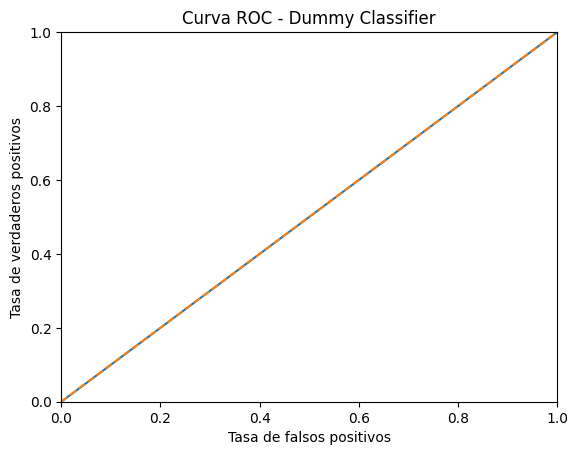

In [229]:
#Entrenamos el modelo y obtenemos las variables para las métricas de evaluación con el conjunto de datos de validación
m_dummy=dc(strategy='most_frequent')
m_dummy.fit(f_train,t_train)
probab=m_dummy.predict_proba(f_valid)
proba_1=probab[:,1]
ras_m_d=ras(t_valid,proba_1)
print(f"El valor auc_roc_score para el modelo es de {ras_m_d:.2}")
predict=m_dummy.predict(f_valid)
acs_m_d=acs(t_valid,predict)
print(f"El valor de accuracy_score para el modelo es de {acs_m_d:.2}")
fpr,tpr,thresholds=roc(t_valid,proba_1)
plt.figure()
plt.plot(fpr,tpr,linestyle='-')
plt.plot([0,1],[0,1],linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC - Dummy Classifier')

### 5.2 Logistic Regression

El valor auc_roc_score para el modelo con solver lbfgs es de 0.84
El valor de accuracy_score para el modelo con solver lbfgs es de 0.75
El valor auc_roc_score para el modelo con solver liblinear es de 0.84
El valor de accuracy_score para el modelo con solver liblinear es de 0.76
El valor auc_roc_score para el modelo con solver newton-cg es de 0.84
El valor de accuracy_score para el modelo con solver newton-cg es de 0.76


C:\Users\555081\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


El valor auc_roc_score para el modelo con solver sag es de 0.82
El valor de accuracy_score para el modelo con solver sag es de 0.74


C:\Users\555081\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


El valor auc_roc_score para el modelo con solver saga es de 0.82
El valor de accuracy_score para el modelo con solver saga es de 0.73


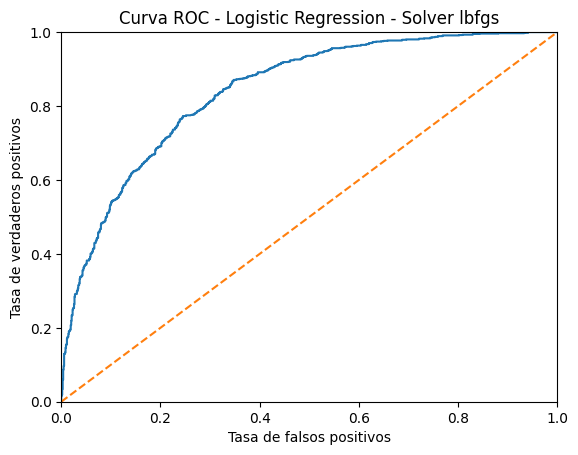

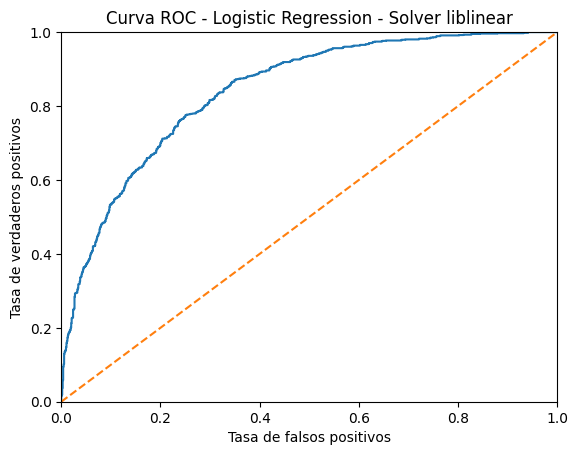

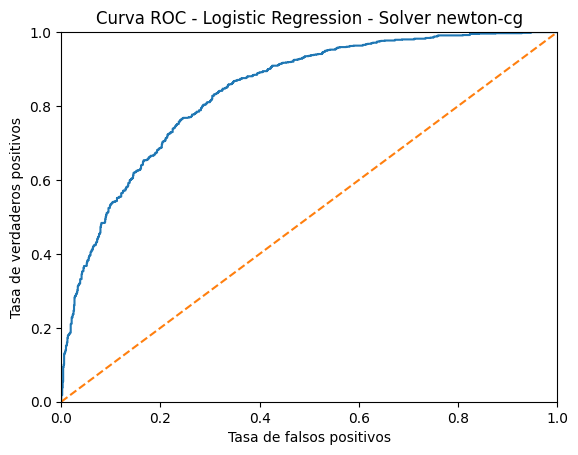

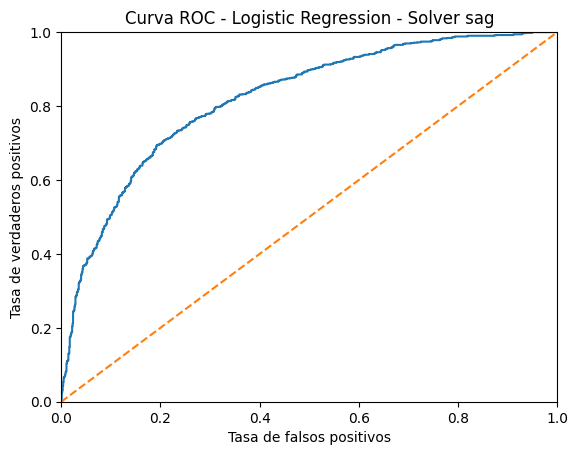

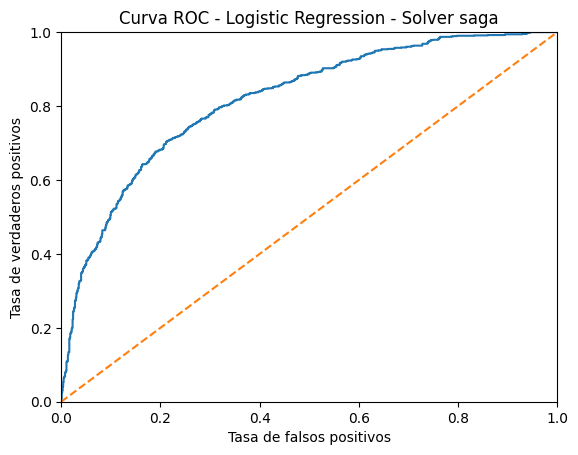

In [230]:
#Entrenamos el modelo y obtenemos las variables para las métricas de evaluación con el conjunto de datos de validación
solvers=['lbfgs','liblinear','newton-cg','sag','saga']
for i in solvers:
    m_lr=lr(solver=i,max_iter=200,random_state=21042407)
    m_lr.fit(f_train,t_train)
    probab=m_lr.predict_proba(f_valid)
    proba_1=probab[:,1]
    ras_m_lr=ras(t_valid,proba_1)
    print(f"El valor auc_roc_score para el modelo con solver {i} es de {ras_m_lr:.2}")
    predict=m_lr.predict(f_valid)
    acs_m_lr=acs(t_valid,predict)
    print(f"El valor de accuracy_score para el modelo con solver {i} es de {acs_m_lr:.2}")
    fpr,tpr,thresholds=roc(t_valid,proba_1)
    plt.figure()
    plt.plot(fpr,tpr,linestyle='-')
    plt.plot([0,1],[0,1],linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel('Tasa de falsos positivos')
    plt.ylabel('Tasa de verdaderos positivos')
    plt.title(f"Curva ROC - Logistic Regression - Solver {i}")

#### 5.2.1 Modelo Seleccionado
Con base en los resultados de entrenamiento y validación, se van a considerar para la prueba con este modelo los solvers lbfgs, liblinear, y newton-cg.
### 5.3 Decision Tree

In [231]:
#Entrenamos el modelo y obtenemos las variables para las métricas de evaluación con el conjunto de datos de validación
#Hiperparámetro max depth - Iniciando con range (10,101,10), se elige el valor 29
for i in range(20,31,1):
    m_dtc=dtc(max_depth=i,random_state=21042407)
    m_dtc.fit(f_train,t_train)
    probab=m_dtc.predict_proba(f_valid)
    proba_1=probab[:,1]
    ras_m_dtc=ras(t_valid,proba_1)
    print(f"Para max_depth de {i}")
    print(f"El valor auc_roc_score es de {ras_m_dtc:.2}")
    predict=m_dtc.predict(f_valid)
    acs_m_dtc=acs(t_valid,predict)
    print(f"El valor de accuracy_score es de {acs_m_dtc:.2}")

Para max_depth de 20
El valor auc_roc_score es de 0.85
El valor de accuracy_score es de 0.84
Para max_depth de 21
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.84
Para max_depth de 22
El valor auc_roc_score es de 0.85
El valor de accuracy_score es de 0.84
Para max_depth de 23
El valor auc_roc_score es de 0.85
El valor de accuracy_score es de 0.84
Para max_depth de 24
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.84
Para max_depth de 25
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.84
Para max_depth de 26
El valor auc_roc_score es de 0.85
El valor de accuracy_score es de 0.84
Para max_depth de 27
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.84
Para max_depth de 28
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.84
Para max_depth de 29
El valor auc_roc_score es de 0.85
El valor de accuracy_score es de 0.85
Para max_depth de 30
El valor auc_roc_score es de 0.85
El valor de acc

In [232]:
#Hiperparámetro min_samples_split - Iniciando con range (10,101,10), no se considera debido a que no mejora las métricas
for i in range(110,201,10):
    m_dtc=dtc(min_samples_split=i,max_depth=29,random_state=21042407)
    m_dtc.fit(f_train,t_train)
    probab=m_dtc.predict_proba(f_valid)
    proba_1=probab[:,1]
    ras_m_dtc=ras(t_valid,proba_1)
    print(f"Para min_samples_split de {i}")
    print(f"El valor auc_roc_score es de {ras_m_dtc:.2}")
    predict=m_dtc.predict(f_valid)
    acs_m_dtc=acs(t_valid,predict)
    print(f"El valor de accuracy_score es de {acs_m_dtc:.2}")

Para min_samples_split de 110
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.75
Para min_samples_split de 120
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.75
Para min_samples_split de 130
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.75
Para min_samples_split de 140
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.75
Para min_samples_split de 150
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.75
Para min_samples_split de 160
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.76
Para min_samples_split de 170
El valor auc_roc_score es de 0.85
El valor de accuracy_score es de 0.76
Para min_samples_split de 180
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.76
Para min_samples_split de 190
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.76
Para min_samples_split de 200
El valor auc_roc_score es de 0.84
El valor de accura

In [233]:
#Hiperparámetro min_samples_leaf - Iniciando con range (10,101,10), no se considera debido a que no mejora las métricas
for i in range(110,201,10):
    m_dtc=dtc(min_samples_leaf=i,max_depth=29,random_state=21042407)
    m_dtc.fit(f_train,t_train)
    probab=m_dtc.predict_proba(f_valid)
    proba_1=probab[:,1]
    ras_m_dtc=ras(t_valid,proba_1)
    print(f"Para min_samples_leaf de {i}")
    print(f"El valor auc_roc_score es de {ras_m_dtc:.2}")
    predict=m_dtc.predict(f_valid)
    acs_m_dtc=acs(t_valid,predict)
    print(f"El valor de accuracy_score es de {acs_m_dtc:.2}")

Para min_samples_leaf de 110
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.77
Para min_samples_leaf de 120
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.77
Para min_samples_leaf de 130
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.76
Para min_samples_leaf de 140
El valor auc_roc_score es de 0.85
El valor de accuracy_score es de 0.76
Para min_samples_leaf de 150
El valor auc_roc_score es de 0.85
El valor de accuracy_score es de 0.76
Para min_samples_leaf de 160
El valor auc_roc_score es de 0.85
El valor de accuracy_score es de 0.76
Para min_samples_leaf de 170
El valor auc_roc_score es de 0.85
El valor de accuracy_score es de 0.76
Para min_samples_leaf de 180
El valor auc_roc_score es de 0.85
El valor de accuracy_score es de 0.76
Para min_samples_leaf de 190
El valor auc_roc_score es de 0.85
El valor de accuracy_score es de 0.76
Para min_samples_leaf de 200
El valor auc_roc_score es de 0.85
El valor de accuracy_score e

In [234]:
#Hiperparámetro max_leaf_nodes - Iniciando con range (10,101,10), no se considera debido a que no mejora las métricas
for i in range(410,501,10):
    m_dtc=dtc(max_leaf_nodes=i,max_depth=29,random_state=21042407)
    m_dtc.fit(f_train,t_train)
    probab=m_dtc.predict_proba(f_valid)
    proba_1=probab[:,1]
    ras_m_dtc=ras(t_valid,proba_1)
    print(f"Para max_leaf_nodes de {i}")
    print(f"El valor auc_roc_score es de {ras_m_dtc:.2}")
    predict=m_dtc.predict(f_valid)
    acs_m_dtc=acs(t_valid,predict)
    print(f"El valor de accuracy_score es de {acs_m_dtc:.2}")

Para max_leaf_nodes de 410
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.82
Para max_leaf_nodes de 420
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.82
Para max_leaf_nodes de 430
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.82
Para max_leaf_nodes de 440
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.82
Para max_leaf_nodes de 450
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.82
Para max_leaf_nodes de 460
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.82
Para max_leaf_nodes de 470
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.82
Para max_leaf_nodes de 480
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.82
Para max_leaf_nodes de 490
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.82
Para max_leaf_nodes de 500
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.82


In [235]:
#Hiperparámetro min_impurity_decrease - Iniciando con range (0.1,1,0.1), no se considera debido a que no mejora las métricas
for i in np.arange(0.0001,0.001,0.0001):
    m_dtc=dtc(min_impurity_decrease=i,max_depth=29,random_state=21042407)
    m_dtc.fit(f_train,t_train)
    probab=m_dtc.predict_proba(f_valid)
    proba_1=probab[:,1]
    ras_m_dtc=ras(t_valid,proba_1)
    print(f"Para min_impurity_decrease de {i}")
    print(f"El valor auc_roc_score es de {ras_m_dtc:.2}")
    predict=m_dtc.predict(f_valid)
    acs_m_dtc=acs(t_valid,predict)
    print(f"El valor de accuracy_score es de {acs_m_dtc:.2}")

Para min_impurity_decrease de 0.0001
El valor auc_roc_score es de 0.83
El valor de accuracy_score es de 0.83
Para min_impurity_decrease de 0.0002
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.82
Para min_impurity_decrease de 0.00030000000000000003
El valor auc_roc_score es de 0.83
El valor de accuracy_score es de 0.78
Para min_impurity_decrease de 0.0004
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.78
Para min_impurity_decrease de 0.0005
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.76
Para min_impurity_decrease de 0.0006000000000000001
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.76
Para min_impurity_decrease de 0.0007000000000000001
El valor auc_roc_score es de 0.85
El valor de accuracy_score es de 0.77
Para min_impurity_decrease de 0.0008
El valor auc_roc_score es de 0.85
El valor de accuracy_score es de 0.77
Para min_impurity_decrease de 0.0009000000000000001
El valor auc_roc_score es de 0

In [236]:
#Hiperparámetro min_weight_fraction_leaf - Iniciando con range (0.1,1,0.1), se elige el valor 0.0001
for i in np.arange(0.0001,0.001,0.0001):
    m_dtc=dtc(min_weight_fraction_leaf=i,max_depth=29,random_state=21042407)
    m_dtc.fit(f_train,t_train)
    probab=m_dtc.predict_proba(f_valid)
    proba_1=probab[:,1]
    ras_m_dtc=ras(t_valid,proba_1)
    print(f"Para min_weight_fraction_leaf de {i}")
    print(f"El valor auc_roc_score es de {ras_m_dtc:.2}")
    predict=m_dtc.predict(f_valid)
    acs_m_dtc=acs(t_valid,predict)
    print(f"El valor de accuracy_score es de {acs_m_dtc:.2}")

Para min_weight_fraction_leaf de 0.0001
El valor auc_roc_score es de 0.85
El valor de accuracy_score es de 0.85
Para min_weight_fraction_leaf de 0.0002
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.79
Para min_weight_fraction_leaf de 0.00030000000000000003
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.79
Para min_weight_fraction_leaf de 0.0004
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.78
Para min_weight_fraction_leaf de 0.0005
El valor auc_roc_score es de 0.85
El valor de accuracy_score es de 0.77
Para min_weight_fraction_leaf de 0.0006000000000000001
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.76
Para min_weight_fraction_leaf de 0.0007000000000000001
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.77
Para min_weight_fraction_leaf de 0.0008
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.77
Para min_weight_fraction_leaf de 0.0009000000000000001
El 

In [237]:
#Hiperparámetro max_features - Iniciando con range (10,101,10), se elige el valor 18
for i in range(16,21,1):
    m_dtc=dtc(max_features=i,min_weight_fraction_leaf=0.0001,max_depth=29,random_state=21042407)
    m_dtc.fit(f_train,t_train)
    probab=m_dtc.predict_proba(f_valid)
    proba_1=probab[:,1]
    ras_m_dtc=ras(t_valid,proba_1)
    print(f"Para max_features de {i}")
    print(f"El valor auc_roc_score es de {ras_m_dtc:.2}")
    predict=m_dtc.predict(f_valid)
    acs_m_dtc=acs(t_valid,predict)
    print(f"El valor de accuracy_score es de {acs_m_dtc:.2}")

Para max_features de 16
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.84
Para max_features de 17
El valor auc_roc_score es de 0.83
El valor de accuracy_score es de 0.83
Para max_features de 18
El valor auc_roc_score es de 0.85
El valor de accuracy_score es de 0.85
Para max_features de 19
El valor auc_roc_score es de 0.85
El valor de accuracy_score es de 0.85
Para max_features de 20
El valor auc_roc_score es de 0.85
El valor de accuracy_score es de 0.85


#### 5.3.1 Modelo Seleccionado

Para los hiperparámetros seleccionados
El valor auc_roc_score es de 0.85
El valor de accuracy_score es de 0.85


Text(0.5, 1.0, 'Curva ROC - Decision Tree Classifier')

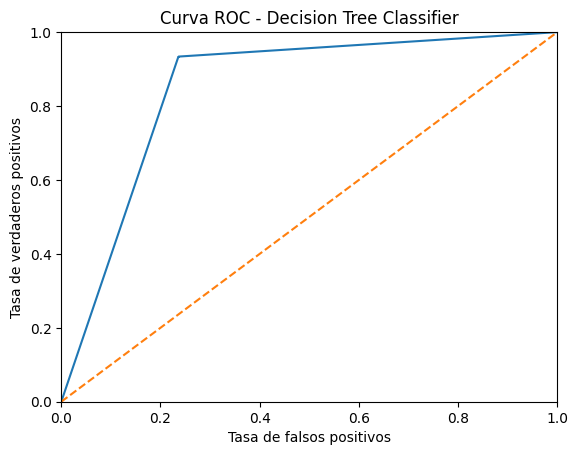

In [238]:
m_dtc=dtc(max_features=18,min_weight_fraction_leaf=0.0001,max_depth=29,random_state=21042407)
m_dtc.fit(f_train,t_train)
probab=m_dtc.predict_proba(f_valid)
proba_1=probab[:,1]
ras_m_dtc=ras(t_valid,proba_1)
print(f"Para los hiperparámetros seleccionados")
print(f"El valor auc_roc_score es de {ras_m_dtc:.2}")
predict=m_dtc.predict(f_valid)
acs_m_dtc=acs(t_valid,predict)
print(f"El valor de accuracy_score es de {acs_m_dtc:.2}")
fpr,tpr,thresholds=roc(t_valid,proba_1)
plt.figure()
plt.plot(fpr,tpr,linestyle='-')
plt.plot([0,1],[0,1],linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title(f"Curva ROC - Decision Tree Classifier")

### 5.4 Random Forest Classifier

In [239]:
#Entrenamos el modelo y obtenemos las variables para las métricas de evaluación con el conjunto de datos de validación
#Hiperparámetro max depth - Iniciando con range (10,101,10), se elige el valor 21
for i in range(20,31,1):
    m_rfc=rfc(max_depth=i,random_state=21042407)
    m_rfc.fit(f_train,t_train)
    probab=m_rfc.predict_proba(f_valid)
    proba_1=probab[:,1]
    ras_m_rfc=ras(t_valid,proba_1)
    print(f"Para max_depth de {i}")
    print(f"El valor auc_roc_score es de {ras_m_rfc:.2}")
    predict=m_rfc.predict(f_valid)
    acs_m_rfc=acs(t_valid,predict)
    print(f"El valor de accuracy_score es de {acs_m_rfc:.2}")

Para max_depth de 20
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.87
Para max_depth de 21
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.88
Para max_depth de 22
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.88
Para max_depth de 23
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.87
Para max_depth de 24
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.88
Para max_depth de 25
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.88
Para max_depth de 26
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.88
Para max_depth de 27
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.87
Para max_depth de 28
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.88
Para max_depth de 29
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.88
Para max_depth de 30
El valor auc_roc_score es de 0.95
El valor de acc

In [240]:
#Hiperparámetro n_estimators - Iniciando con range (10,101,10), se elige el valor 24
for i in range(23,30,1):
    m_rfc=rfc(n_estimators=i,max_depth=21,random_state=21042407)
    m_rfc.fit(f_train,t_train)
    probab=m_rfc.predict_proba(f_valid)
    proba_1=probab[:,1]
    ras_m_rfc=ras(t_valid,proba_1)
    print(f"Para n_estimators de {i}")
    print(f"El valor auc_roc_score es de {ras_m_rfc:.2}")
    predict=m_rfc.predict(f_valid)
    acs_m_rfc=acs(t_valid,predict)
    print(f"El valor de accuracy_score es de {acs_m_rfc:.2}")

Para n_estimators de 23
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.86
Para n_estimators de 24
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.87
Para n_estimators de 25
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.87
Para n_estimators de 26
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.87
Para n_estimators de 27
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.87
Para n_estimators de 28
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.87
Para n_estimators de 29
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.86


In [241]:
#Hiperparámetro min_samples_split - Iniciando con range (10,101,10), no se considera debido a que no mejora las métricas
for i in range(2,11,1):
    m_rfc=rfc(min_samples_split=i,n_estimators=24,max_depth=21,random_state=21042407)
    m_rfc.fit(f_train,t_train)
    probab=m_rfc.predict_proba(f_valid)
    proba_1=probab[:,1]
    ras_m_rfc=ras(t_valid,proba_1)
    print(f"Para min_samples_split de {i}")
    print(f"El valor auc_roc_score es de {ras_m_rfc:.2}")
    predict=m_rfc.predict(f_valid)
    acs_m_rfc=acs(t_valid,predict)
    print(f"El valor de accuracy_score es de {acs_m_rfc:.2}")

Para min_samples_split de 2
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.87
Para min_samples_split de 3
El valor auc_roc_score es de 0.94
El valor de accuracy_score es de 0.87
Para min_samples_split de 4
El valor auc_roc_score es de 0.94
El valor de accuracy_score es de 0.86
Para min_samples_split de 5
El valor auc_roc_score es de 0.93
El valor de accuracy_score es de 0.85
Para min_samples_split de 6
El valor auc_roc_score es de 0.92
El valor de accuracy_score es de 0.85
Para min_samples_split de 7
El valor auc_roc_score es de 0.92
El valor de accuracy_score es de 0.85
Para min_samples_split de 8
El valor auc_roc_score es de 0.92
El valor de accuracy_score es de 0.84
Para min_samples_split de 9
El valor auc_roc_score es de 0.91
El valor de accuracy_score es de 0.83
Para min_samples_split de 10
El valor auc_roc_score es de 0.91
El valor de accuracy_score es de 0.83


In [242]:
#Hiperparámetro min_samples_leaf - Iniciando con range (10,101,10), no se considera debido a que no mejora las métricas
for i in range(2,11,1):
    m_rfc=rfc(min_samples_leaf=i,n_estimators=24,max_depth=21,random_state=21042407)
    m_rfc.fit(f_train,t_train)
    probab=m_rfc.predict_proba(f_valid)
    proba_1=probab[:,1]
    ras_m_rfc=ras(t_valid,proba_1)
    print(f"Para min_samples_leaf de {i}")
    print(f"El valor auc_roc_score es de {ras_m_rfc:.2}")
    predict=m_rfc.predict(f_valid)
    acs_m_rfc=acs(t_valid,predict)
    print(f"El valor de accuracy_score es de {acs_m_rfc:.2}")

Para min_samples_leaf de 2
El valor auc_roc_score es de 0.92
El valor de accuracy_score es de 0.84
Para min_samples_leaf de 3
El valor auc_roc_score es de 0.91
El valor de accuracy_score es de 0.83
Para min_samples_leaf de 4
El valor auc_roc_score es de 0.9
El valor de accuracy_score es de 0.82
Para min_samples_leaf de 5
El valor auc_roc_score es de 0.89
El valor de accuracy_score es de 0.81
Para min_samples_leaf de 6
El valor auc_roc_score es de 0.89
El valor de accuracy_score es de 0.8
Para min_samples_leaf de 7
El valor auc_roc_score es de 0.88
El valor de accuracy_score es de 0.8
Para min_samples_leaf de 8
El valor auc_roc_score es de 0.88
El valor de accuracy_score es de 0.8
Para min_samples_leaf de 9
El valor auc_roc_score es de 0.88
El valor de accuracy_score es de 0.8
Para min_samples_leaf de 10
El valor auc_roc_score es de 0.88
El valor de accuracy_score es de 0.79


In [243]:
#Hiperparámetro min_weight_fraction_leaf - Iniciando con range (10,101,10), no se considera debido a que no mejora las métricas
for i in np.arange(0.0001,0.001,0.0001):
    m_rfc=rfc(min_weight_fraction_leaf=i,n_estimators=24,max_depth=21,random_state=21042407)
    m_rfc.fit(f_train,t_train)
    probab=m_rfc.predict_proba(f_valid)
    proba_1=probab[:,1]
    ras_m_rfc=ras(t_valid,proba_1)
    print(f"Para min_weight_fraction_leaf de {i}")
    print(f"El valor auc_roc_score es de {ras_m_rfc:.2}")
    predict=m_rfc.predict(f_valid)
    acs_m_rfc=acs(t_valid,predict)
    print(f"El valor de accuracy_score es de {acs_m_rfc:.2}")

Para min_weight_fraction_leaf de 0.0001
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.87
Para min_weight_fraction_leaf de 0.0002
El valor auc_roc_score es de 0.93
El valor de accuracy_score es de 0.85
Para min_weight_fraction_leaf de 0.00030000000000000003
El valor auc_roc_score es de 0.93
El valor de accuracy_score es de 0.86
Para min_weight_fraction_leaf de 0.0004
El valor auc_roc_score es de 0.92
El valor de accuracy_score es de 0.84
Para min_weight_fraction_leaf de 0.0005
El valor auc_roc_score es de 0.91
El valor de accuracy_score es de 0.84
Para min_weight_fraction_leaf de 0.0006000000000000001
El valor auc_roc_score es de 0.91
El valor de accuracy_score es de 0.83
Para min_weight_fraction_leaf de 0.0007000000000000001
El valor auc_roc_score es de 0.9
El valor de accuracy_score es de 0.83
Para min_weight_fraction_leaf de 0.0008
El valor auc_roc_score es de 0.9
El valor de accuracy_score es de 0.82
Para min_weight_fraction_leaf de 0.0009000000000000001
El va

In [244]:
#Hiperparámetro max_features - Iniciando con range (10,101,10), no se considera debido a que no mejora las métricas
for i in range(2,11,1):
    m_rfc=rfc(max_features=i,n_estimators=24,max_depth=21,random_state=21042407)
    m_rfc.fit(f_train,t_train)
    probab=m_rfc.predict_proba(f_valid)
    proba_1=probab[:,1]
    ras_m_rfc=ras(t_valid,proba_1)
    print(f"Para max_features de {i}")
    print(f"El valor auc_roc_score es de {ras_m_rfc:.2}")
    predict=m_rfc.predict(f_valid)
    acs_m_rfc=acs(t_valid,predict)
    print(f"El valor de accuracy_score es de {acs_m_rfc:.2}")

Para max_features de 2
El valor auc_roc_score es de 0.94
El valor de accuracy_score es de 0.86
Para max_features de 3
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.87
Para max_features de 4
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.87
Para max_features de 5
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.87
Para max_features de 6
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.87
Para max_features de 7
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.87
Para max_features de 8
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.87
Para max_features de 9
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.87
Para max_features de 10
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.87


#### 5.4.1 Modelo Seleccionado

Para los hiperparámetros seleccionados
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.87


Text(0.5, 1.0, 'Curva ROC - Random Forest Classifier')

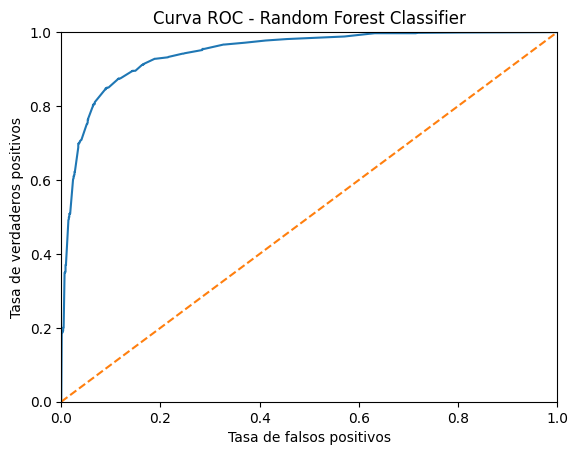

In [245]:
m_rfc=rfc(n_estimators=24,max_depth=21,random_state=21042407)
m_rfc.fit(f_train,t_train)
probab=m_rfc.predict_proba(f_valid)
proba_1=probab[:,1]
ras_m_rfc=ras(t_valid,proba_1)
print(f"Para los hiperparámetros seleccionados")
print(f"El valor auc_roc_score es de {ras_m_rfc:.2}")
predict=m_rfc.predict(f_valid)
acs_m_rfc=acs(t_valid,predict)
print(f"El valor de accuracy_score es de {acs_m_rfc:.2}")
fpr,tpr,thresholds=roc(t_valid,proba_1)
plt.figure()
plt.plot(fpr,tpr,linestyle='-')
plt.plot([0,1],[0,1],linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title(f"Curva ROC - Random Forest Classifier")

### 5.5 CatBoost Classifier

In [246]:
#Entrenamos el modelo y obtenemos las variables para las métricas de evaluación con el conjunto de datos de validación
#Hiperparámetro iterations - Iniciando con range (10,101,10), se elige el valor 45
for i in range(43,47,1):
    m_cbc=cbc(iterations=i,loss_function='Logloss',verbose=False,random_seed=21042407)
    m_cbc.fit(f_train,t_train)
    probab=m_cbc.predict_proba(f_valid)
    proba_1=probab[:,1]
    ras_m_cbc=ras(t_valid,proba_1)
    print(f"Para iterations de {i}")
    print(f"El valor auc_roc_score es de {ras_m_cbc:.2}")
    predict=m_cbc.predict(f_valid)
    acs_m_cbc=acs(t_valid,predict)
    print(f"El valor de accuracy_score es de {acs_m_cbc:.2}")

Para iterations de 43
El valor auc_roc_score es de 0.87
El valor de accuracy_score es de 0.79
Para iterations de 44
El valor auc_roc_score es de 0.87
El valor de accuracy_score es de 0.79
Para iterations de 45
El valor auc_roc_score es de 0.87
El valor de accuracy_score es de 0.8
Para iterations de 46
El valor auc_roc_score es de 0.87
El valor de accuracy_score es de 0.78


In [247]:
#Hiperparámetro depth - Iniciando con range (2,17,2), se elige el valor 15
for i in range(13,17,1):
    m_cbc=cbc(depth=i,iterations=45,loss_function='Logloss',verbose=False,random_seed=21042407)
    m_cbc.fit(f_train,t_train)
    probab=m_cbc.predict_proba(f_valid)
    proba_1=probab[:,1]
    ras_m_cbc=ras(t_valid,proba_1)
    print(f"Para depth de {i}")
    print(f"El valor auc_roc_score es de {ras_m_cbc:.2}")
    predict=m_cbc.predict(f_valid)
    acs_m_cbc=acs(t_valid,predict)
    print(f"El valor de accuracy_score es de {acs_m_cbc:.2}")

Para depth de 13
El valor auc_roc_score es de 0.91
El valor de accuracy_score es de 0.84
Para depth de 14
El valor auc_roc_score es de 0.91
El valor de accuracy_score es de 0.84
Para depth de 15
El valor auc_roc_score es de 0.92
El valor de accuracy_score es de 0.84
Para depth de 16
El valor auc_roc_score es de 0.92
El valor de accuracy_score es de 0.84


In [248]:
#Hiperparámetro max_depth - Iniciando con range (2,17,2), se elige el valor 15
for i in range(13,17,1):
    m_cbc=cbc(max_depth=i,iterations=45,loss_function='Logloss',verbose=False,random_seed=21042407)
    m_cbc.fit(f_train,t_train)
    probab=m_cbc.predict_proba(f_valid)
    proba_1=probab[:,1]
    ras_m_cbc=ras(t_valid,proba_1)
    print(f"Para max_depth de {i}")
    print(f"El valor auc_roc_score es de {ras_m_cbc:.2}")
    predict=m_cbc.predict(f_valid)
    acs_m_cbc=acs(t_valid,predict)
    print(f"El valor de accuracy_score es de {acs_m_cbc:.2}")

Para max_depth de 13
El valor auc_roc_score es de 0.91
El valor de accuracy_score es de 0.84
Para max_depth de 14
El valor auc_roc_score es de 0.91
El valor de accuracy_score es de 0.84
Para max_depth de 15
El valor auc_roc_score es de 0.92
El valor de accuracy_score es de 0.84
Para max_depth de 16
El valor auc_roc_score es de 0.92
El valor de accuracy_score es de 0.84


In [249]:
#Hiperparámetro n_estimators - Iniciando con range (10,101,10), se elige el valor 50
for i in range(10,101,10):
    m_cbc=cbc(n_estimators=i,max_depth=15,loss_function='Logloss',verbose=False,random_seed=21042407)
    m_cbc.fit(f_train,t_train)
    probab=m_cbc.predict_proba(f_valid)
    proba_1=probab[:,1]
    ras_m_cbc=ras(t_valid,proba_1)
    print(f"Para n_estimators de {i}")
    print(f"El valor auc_roc_score es de {ras_m_cbc:.2}")
    predict=m_cbc.predict(f_valid)
    acs_m_cbc=acs(t_valid,predict)
    print(f"El valor de accuracy_score es de {acs_m_cbc:.2}")

Para n_estimators de 10
El valor auc_roc_score es de 0.89
El valor de accuracy_score es de 0.81
Para n_estimators de 20
El valor auc_roc_score es de 0.9
El valor de accuracy_score es de 0.82
Para n_estimators de 30
El valor auc_roc_score es de 0.91
El valor de accuracy_score es de 0.83
Para n_estimators de 40
El valor auc_roc_score es de 0.92
El valor de accuracy_score es de 0.84
Para n_estimators de 50
El valor auc_roc_score es de 0.92
El valor de accuracy_score es de 0.85
Para n_estimators de 60
El valor auc_roc_score es de 0.92
El valor de accuracy_score es de 0.85
Para n_estimators de 70
El valor auc_roc_score es de 0.92
El valor de accuracy_score es de 0.84
Para n_estimators de 80
El valor auc_roc_score es de 0.92
El valor de accuracy_score es de 0.85
Para n_estimators de 90
El valor auc_roc_score es de 0.92
El valor de accuracy_score es de 0.84
Para n_estimators de 100
El valor auc_roc_score es de 0.92
El valor de accuracy_score es de 0.84


In [250]:
#Hiperparámetro max_leaves - Iniciando con range (10,101,10), se elige el valor 50
for i in range(2,11,1):
    m_cbc=cbc(min_data_in_leaf=i,n_estimators=50,max_depth=15,loss_function='Logloss',verbose=False,random_seed=21042407)
    m_cbc.fit(f_train,t_train)
    probab=m_cbc.predict_proba(f_valid)
    proba_1=probab[:,1]
    ras_m_cbc=ras(t_valid,proba_1)
    print(f"Para max_leaves de {i}")
    print(f"El valor auc_roc_score es de {ras_m_cbc:.2}")
    predict=m_cbc.predict(f_valid)
    acs_m_cbc=acs(t_valid,predict)
    print(f"El valor de accuracy_score es de {acs_m_cbc:.2}")

Para max_leaves de 2
El valor auc_roc_score es de 0.92
El valor de accuracy_score es de 0.85
Para max_leaves de 3
El valor auc_roc_score es de 0.92
El valor de accuracy_score es de 0.85
Para max_leaves de 4
El valor auc_roc_score es de 0.92
El valor de accuracy_score es de 0.85
Para max_leaves de 5
El valor auc_roc_score es de 0.92
El valor de accuracy_score es de 0.85
Para max_leaves de 6
El valor auc_roc_score es de 0.92
El valor de accuracy_score es de 0.85
Para max_leaves de 7
El valor auc_roc_score es de 0.92
El valor de accuracy_score es de 0.85
Para max_leaves de 8
El valor auc_roc_score es de 0.92
El valor de accuracy_score es de 0.85
Para max_leaves de 9
El valor auc_roc_score es de 0.92
El valor de accuracy_score es de 0.85
Para max_leaves de 10
El valor auc_roc_score es de 0.92
El valor de accuracy_score es de 0.85


#### 5.5.1 Modelo Seleccionado

Para los hiperparámetros seleccionados
El valor auc_roc_score es de 0.92
El valor de accuracy_score es de 0.85


Text(0.5, 1.0, 'Curva ROC - CatBoost Classifier')

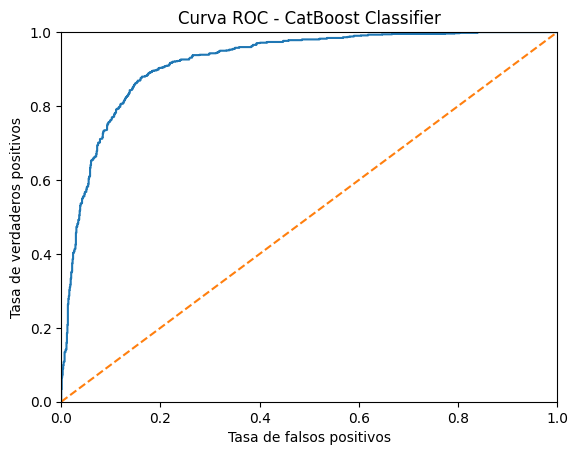

In [251]:
m_cbc=cbc(n_estimators=50,max_depth=15,loss_function='Logloss',verbose=False,random_seed=21042407)
m_cbc.fit(f_train,t_train)
probab=m_cbc.predict_proba(f_valid)
proba_1=probab[:,1]
ras_m_cbc=ras(t_valid,proba_1)
print(f"Para los hiperparámetros seleccionados")
print(f"El valor auc_roc_score es de {ras_m_cbc:.2}")
predict=m_cbc.predict(f_valid)
acs_m_cbc=acs(t_valid,predict)
print(f"El valor de accuracy_score es de {acs_m_cbc:.2}")
fpr,tpr,thresholds=roc(t_valid,proba_1)
plt.figure()
plt.plot(fpr,tpr,linestyle='-')
plt.plot([0,1],[0,1],linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title(f"Curva ROC - CatBoost Classifier")

### 5.6 Comparación de Resultados

In [252]:
modelo=['Dummy Classifier','Logistic Regression', 'Decision Tree Classifier', 'Random Forest Classifier', 'CatBoost Classifier']
auc_roc_score=[ras_m_d.round(2),ras_m_lr.round(2),ras_m_dtc.round(2),ras_m_rfc.round(2),ras_m_cbc.round(2)]
acs_m_score=[acs_m_d.round(2),acs_m_lr.round(2),acs_m_dtc.round(2),acs_m_rfc.round(2),acs_m_cbc.round(2)]

In [253]:
comparacion=pd.DataFrame({'Modelo':modelo,'AUC_ROC':auc_roc_score,'Accuracy':acs_m_score})
comparacion

,Modelo,AUC_ROC,Accuracy
0,Dummy Classifier,0.50,0.49
1,Logistic Regression,0.82,0.73
2,Decision Tree Classifier,0.85,0.85
3,Random Forest Classifier,0.95,0.87
4,CatBoost Classifier,0.92,0.85


## 6. Entrenamiento de Modelos Escalados

En los diferentes modelos que se entrenen, se usarán los datos previamente escalados, para comparar las diferencias con los resultados de la sección anterior.

### 6.1 Dummy Classifier

El valor auc_roc_score para el modelo es de 0.5
El valor de accuracy_score para el modelo es de 0.49


Text(0.5, 1.0, 'Curva ROC - Dummy Classifier')

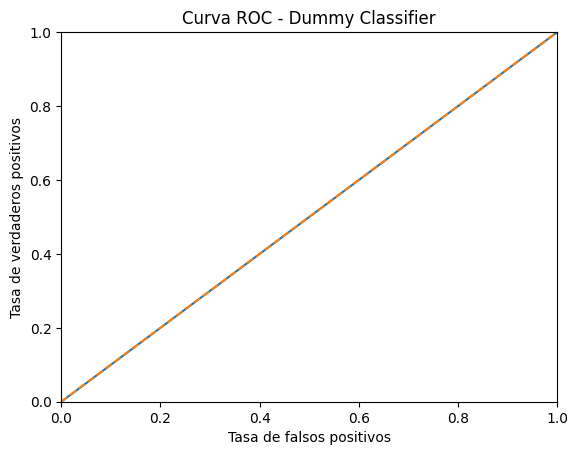

In [254]:
#Entrenamos el modelo y obtenemos las variables para las métricas de evaluación con el conjunto de datos de validación
m_dummy=dc(strategy='most_frequent')
m_dummy.fit(f_train_s,t_train)
probab=m_dummy.predict_proba(f_valid_s)
proba_1=probab[:,1]
ras_m_d=ras(t_valid,proba_1)
print(f"El valor auc_roc_score para el modelo es de {ras_m_d:.2}")
predict=m_dummy.predict(f_valid)
acs_m_d=acs(t_valid,predict)
print(f"El valor de accuracy_score para el modelo es de {acs_m_d:.2}")
fpr,tpr,thresholds=roc(t_valid,proba_1)
plt.figure()
plt.plot(fpr,tpr,linestyle='-')
plt.plot([0,1],[0,1],linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC - Dummy Classifier')

### 6.2 Logistic Regression

El valor auc_roc_score para el modelo con solver lbfgs es de 0.84
El valor de accuracy_score para el modelo con solver lbfgs es de 0.76
El valor auc_roc_score para el modelo con solver liblinear es de 0.84
El valor de accuracy_score para el modelo con solver liblinear es de 0.76
El valor auc_roc_score para el modelo con solver newton-cg es de 0.84
El valor de accuracy_score para el modelo con solver newton-cg es de 0.76


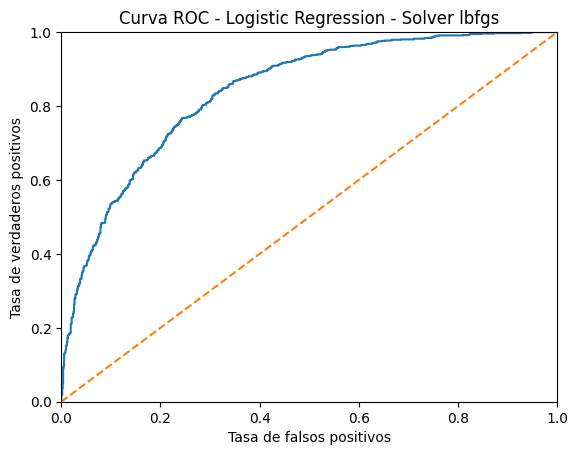

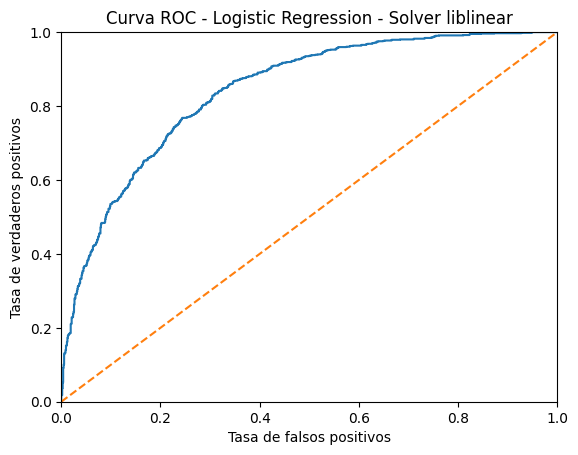

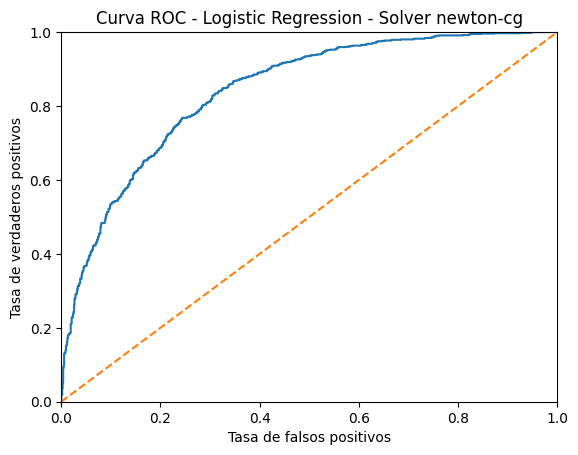

In [255]:
#Entrenamos el modelo y obtenemos las variables para las métricas de evaluación con el conjunto de datos de validación
solvers=['lbfgs','liblinear','newton-cg']
for i in solvers:
    m_lr=lr(solver=i,max_iter=200,random_state=21042407)
    m_lr.fit(f_train_s,t_train)
    probab=m_lr.predict_proba(f_valid_s)
    proba_1=probab[:,1]
    ras_m_lr=ras(t_valid,proba_1)
    print(f"El valor auc_roc_score para el modelo con solver {i} es de {ras_m_lr:.2}")
    predict=m_lr.predict(f_valid_s)
    acs_m_lr=acs(t_valid,predict)
    print(f"El valor de accuracy_score para el modelo con solver {i} es de {acs_m_lr:.2}")
    fpr,tpr,thresholds=roc(t_valid,proba_1)
    plt.figure()
    plt.plot(fpr,tpr,linestyle='-')
    plt.plot([0,1],[0,1],linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel('Tasa de falsos positivos')
    plt.ylabel('Tasa de verdaderos positivos')
    plt.title(f"Curva ROC - Logistic Regression - Solver {i}")

### 6.3 Decision Tree

Para los hiperparámetros seleccionados
El valor auc_roc_score es de 0.85
El valor de accuracy_score es de 0.85


Text(0.5, 1.0, 'Curva ROC - Decision Tree Classifier')

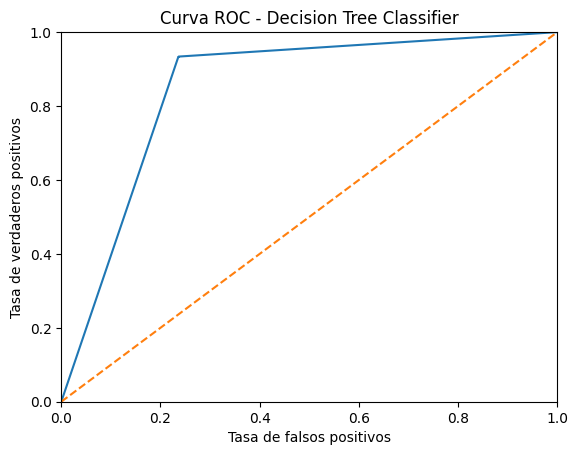

In [256]:
m_dtc=dtc(max_features=18,min_weight_fraction_leaf=0.0001,max_depth=29,random_state=21042407)
m_dtc.fit(f_train_s,t_train)
probab=m_dtc.predict_proba(f_valid_s)
proba_1=probab[:,1]
ras_m_dtc=ras(t_valid,proba_1)
print(f"Para los hiperparámetros seleccionados")
print(f"El valor auc_roc_score es de {ras_m_dtc:.2}")
predict=m_dtc.predict(f_valid_s)
acs_m_dtc=acs(t_valid,predict)
print(f"El valor de accuracy_score es de {acs_m_dtc:.2}")
fpr,tpr,thresholds=roc(t_valid,proba_1)
plt.figure()
plt.plot(fpr,tpr,linestyle='-')
plt.plot([0,1],[0,1],linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title(f"Curva ROC - Decision Tree Classifier")

### 6.4 Random Forest

Para los hiperparámetros seleccionados
El valor auc_roc_score es de 0.95
El valor de accuracy_score es de 0.87


Text(0.5, 1.0, 'Curva ROC - Random Forest Classifier')

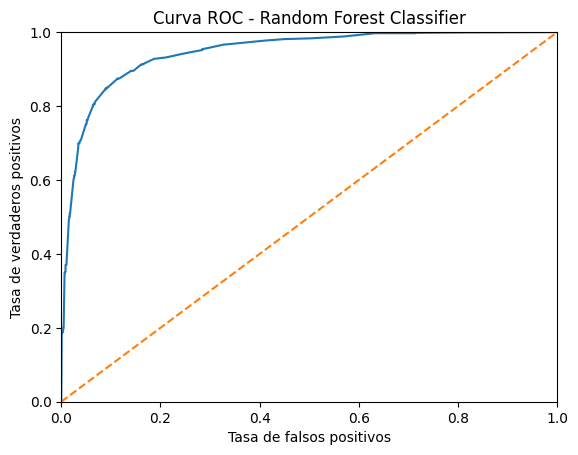

In [257]:
m_rfc=rfc(n_estimators=24,max_depth=21,random_state=21042407)
m_rfc.fit(f_train_s,t_train)
probab=m_rfc.predict_proba(f_valid_s)
proba_1=probab[:,1]
ras_m_rfc=ras(t_valid,proba_1)
print(f"Para los hiperparámetros seleccionados")
print(f"El valor auc_roc_score es de {ras_m_rfc:.2}")
predict=m_rfc.predict(f_valid_s)
acs_m_rfc=acs(t_valid,predict)
print(f"El valor de accuracy_score es de {acs_m_rfc:.2}")
fpr,tpr,thresholds=roc(t_valid,proba_1)
plt.figure()
plt.plot(fpr,tpr,linestyle='-')
plt.plot([0,1],[0,1],linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title(f"Curva ROC - Random Forest Classifier")

### 6.5 CatBoost Classifier

Para los hiperparámetros seleccionados
El valor auc_roc_score es de 0.92
El valor de accuracy_score es de 0.85


Text(0.5, 1.0, 'Curva ROC - CatBoost Classifier')

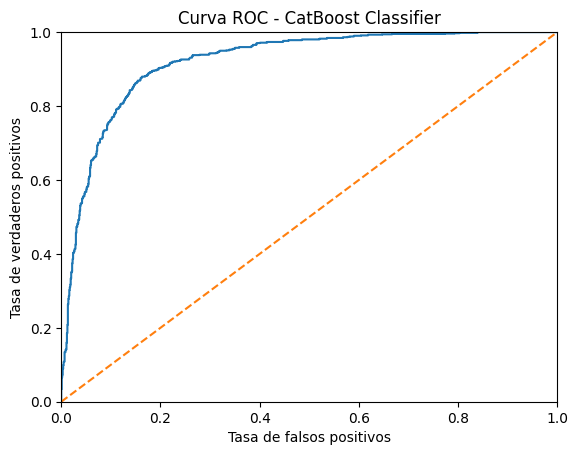

In [258]:
m_cbc=cbc(n_estimators=50,max_depth=15,loss_function='Logloss',verbose=False,random_seed=21042407)
m_cbc.fit(f_train_s,t_train)
probab=m_cbc.predict_proba(f_valid_s)
proba_1=probab[:,1]
ras_m_cbc=ras(t_valid,proba_1)
print(f"Para los hiperparámetros seleccionados")
print(f"El valor auc_roc_score es de {ras_m_cbc:.2}")
predict=m_cbc.predict(f_valid_s)
acs_m_cbc=acs(t_valid,predict)
print(f"El valor de accuracy_score es de {acs_m_cbc:.2}")
fpr,tpr,thresholds=roc(t_valid,proba_1)
plt.figure()
plt.plot(fpr,tpr,linestyle='-')
plt.plot([0,1],[0,1],linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title(f"Curva ROC - CatBoost Classifier")

### 6.6 Comparación de Resultados

In [259]:
auc_roc_score_escal=[ras_m_d.round(2),ras_m_lr.round(2),ras_m_dtc.round(2),ras_m_rfc.round(2),ras_m_cbc.round(2)]
acs_m_score_escal=[acs_m_d.round(2),acs_m_lr.round(2),acs_m_dtc.round(2),acs_m_rfc.round(2),acs_m_cbc.round(2)]

In [260]:
comparacion['AUC_ROC_Escalado']=auc_roc_score_escal
comparacion['Accuracy_Escalado']=acs_m_score_escal
comparacion

,Modelo,AUC_ROC,Accuracy,AUC_ROC_Escalado,Accuracy_Escalado
0,Dummy Classifier,0.50,0.49,0.50,0.49
1,Logistic Regression,0.82,0.73,0.84,0.76
2,Decision Tree Classifier,0.85,0.85,0.85,0.85
3,Random Forest Classifier,0.95,0.87,0.95,0.87
4,CatBoost Classifier,0.92,0.85,0.92,0.85


## 7. Prueba de Modelos

Se probarán los modelos seleccionados, con los conjuntos de prueba y los datos sin escalar. 

### 7.1 Logistic Regression

El valor auc_roc_score para el modelo con solver lbfgs es de 0.85
El valor de accuracy_score para el modelo con solver lbfgs es de 0.77
El valor auc_roc_score para el modelo con solver liblinear es de 0.85
El valor de accuracy_score para el modelo con solver liblinear es de 0.77
El valor auc_roc_score para el modelo con solver newton-cg es de 0.84
El valor de accuracy_score para el modelo con solver newton-cg es de 0.77


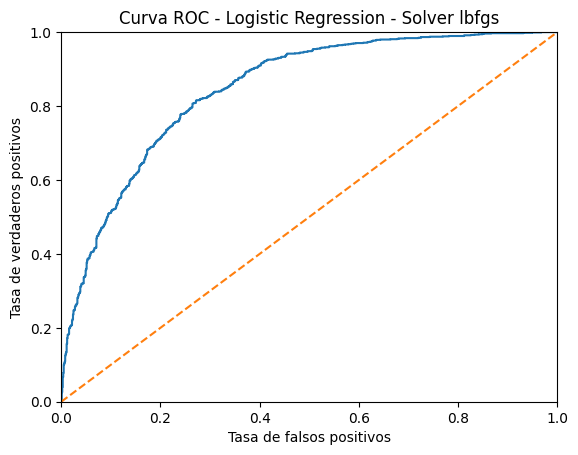

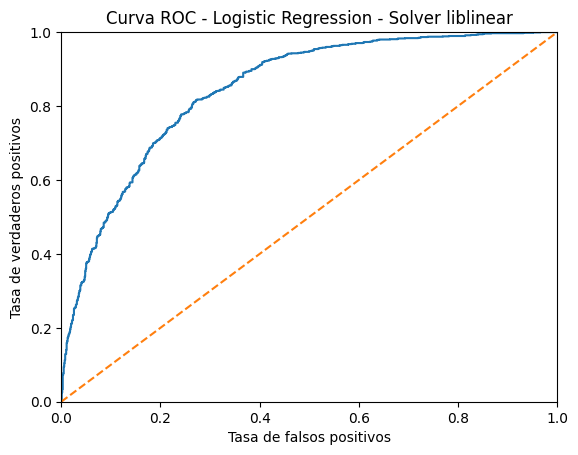

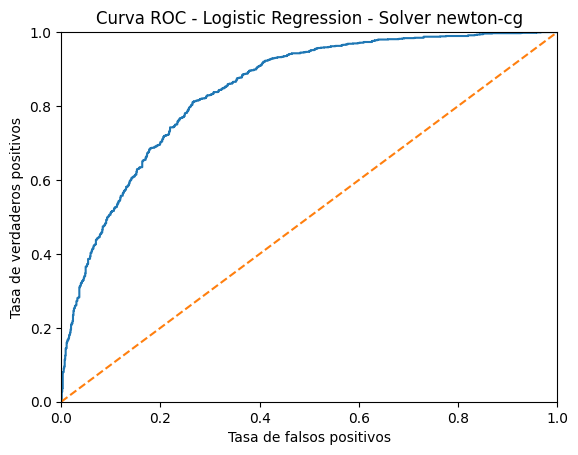

In [261]:
#Probamos el modelo y obtenemos las variables para las métricas de evaluación con el conjunto de datos de validación
solvers=['lbfgs','liblinear','newton-cg']
for i in solvers:
    m_lr=lr(solver=i,max_iter=200,random_state=21042407)
    m_lr.fit(f_train,t_train)
    probab=m_lr.predict_proba(f_test)
    proba_1=probab[:,1]
    ras_m_lr=ras(t_test,proba_1)
    print(f"El valor auc_roc_score para el modelo con solver {i} es de {ras_m_lr:.2}")
    predict=m_lr.predict(f_test)
    acs_m_lr=acs(t_test,predict)
    print(f"El valor de accuracy_score para el modelo con solver {i} es de {acs_m_lr:.2}")
    fpr,tpr,thresholds=roc(t_test,proba_1)
    plt.figure()
    plt.plot(fpr,tpr,linestyle='-')
    plt.plot([0,1],[0,1],linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel('Tasa de falsos positivos')
    plt.ylabel('Tasa de verdaderos positivos')
    plt.title(f"Curva ROC - Logistic Regression - Solver {i}")

### 7.2 Decision Tree

Para los hiperparámetros seleccionados
El valor auc_roc_score es de 0.84
El valor de accuracy_score es de 0.84


Text(0.5, 1.0, 'Curva ROC - Decision Tree Classifier')

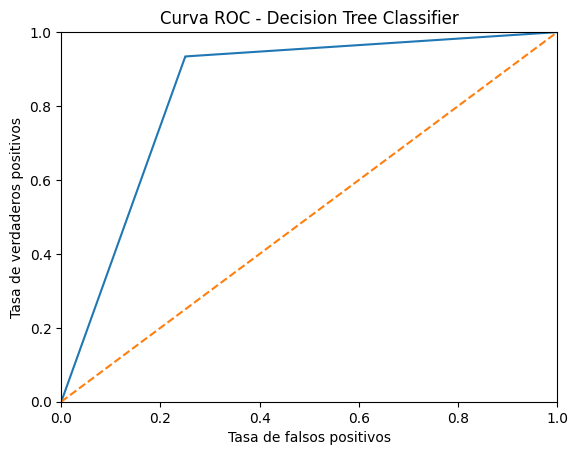

In [262]:
#Probamos el modelo y obtenemos las variables para las métricas de evaluación con el conjunto de datos de validación
m_dtc=dtc(max_features=18,min_weight_fraction_leaf=0.0001,max_depth=29,random_state=21042407)
m_dtc.fit(f_train,t_train)
probab=m_dtc.predict_proba(f_test)
proba_1=probab[:,1]
ras_m_dtc=ras(t_test,proba_1)
print(f"Para los hiperparámetros seleccionados")
print(f"El valor auc_roc_score es de {ras_m_dtc:.2}")
predict=m_dtc.predict(f_test)
acs_m_dtc=acs(t_test,predict)
print(f"El valor de accuracy_score es de {acs_m_dtc:.2}")
fpr,tpr,thresholds=roc(t_test,proba_1)
plt.figure()
plt.plot(fpr,tpr,linestyle='-')
plt.plot([0,1],[0,1],linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title(f"Curva ROC - Decision Tree Classifier")

### 7.3 Random Forest

Para los hiperparámetros seleccionados
El valor auc_roc_score es de 0.94
El valor de accuracy_score es de 0.87


Text(0.5, 1.0, 'Curva ROC - Random Forest Classifier')

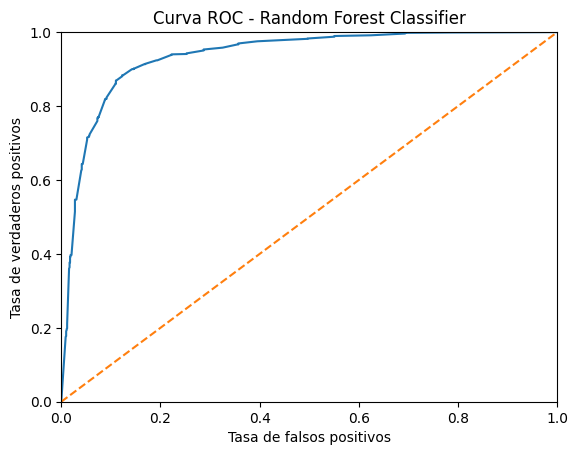

In [263]:
#Probamos el modelo y obtenemos las variables para las métricas de evaluación con el conjunto de datos de validación
m_rfc=rfc(n_estimators=24,max_depth=21,random_state=21042407)
m_rfc.fit(f_train,t_train)
probab=m_rfc.predict_proba(f_test)
proba_1=probab[:,1]
ras_m_rfc=ras(t_test,proba_1)
print(f"Para los hiperparámetros seleccionados")
print(f"El valor auc_roc_score es de {ras_m_rfc:.2}")
predict=m_rfc.predict(f_test)
acs_m_rfc=acs(t_test,predict)
print(f"El valor de accuracy_score es de {acs_m_rfc:.2}")
fpr,tpr,thresholds=roc(t_test,proba_1)
plt.figure()
plt.plot(fpr,tpr,linestyle='-')
plt.plot([0,1],[0,1],linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title(f"Curva ROC - Random Forest Classifier")

### 7.4 CatBoost Classifier

Para los hiperparámetros seleccionados
El valor auc_roc_score es de 0.9
El valor de accuracy_score es de 0.85


Text(0.5, 1.0, 'Curva ROC - CatBoost Classifier')

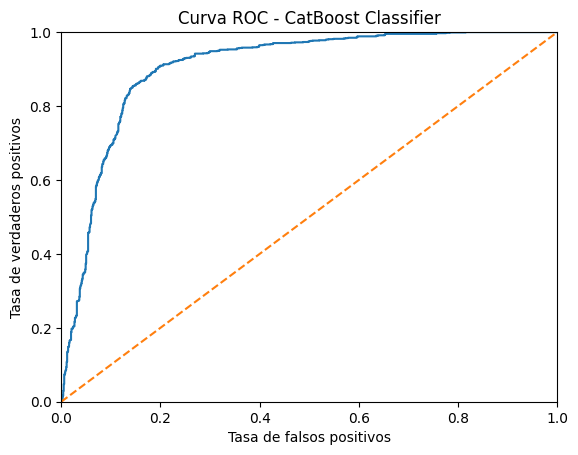

In [264]:
#Probamos el modelo y obtenemos las variables para las métricas de evaluación con el conjunto de datos de validación
m_cbc=cbc(n_estimators=50,max_depth=15,loss_function='Logloss',verbose=False,random_seed=21042407)
m_cbc.fit(f_train,t_train)
probab=m_cbc.predict_proba(f_test)
proba_1=probab[:,1]
ras_m_cbc=ras(t_test,proba_1)
print(f"Para los hiperparámetros seleccionados")
print(f"El valor auc_roc_score es de {ras_m_cbc:.2}")
predict=m_cbc.predict(f_test)
acs_m_cbc=acs(t_test,predict)
print(f"El valor de accuracy_score es de {acs_m_cbc:.2}")
fpr,tpr,thresholds=roc(t_test,proba_1)
plt.figure()
plt.plot(fpr,tpr,linestyle='-')
plt.plot([0,1],[0,1],linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title(f"Curva ROC - CatBoost Classifier")

## 8. Informe de Solución
### 8.1 Seguimiento del Plan de Trabajo

A continuación se presenta un resumen de lo realizado y comentarios importantes de cada paso del Plan de trabajo: 

1. Conversión de dataframes originales.
    
    Se utilizan técnicas para convertir las variables categóricas a numéricas. Adicionalmente, para tomar en cuenta la columna de la fecha de inicio de contrato, se realiza un cálculo que refleja aproximadamente los meses que un contrato ha estado pagando sus servicios; esto se realiza al dividir el monto total, entre el monto mensual.
   
3. Creación de dataframe final.

     Se realiza la unión de los dataframes modificados en el paso 1. Debido a las consideraciones tomadas en el análisis exploratorio de datos, dónde se decidió no considerar a aquellos contratos que aún no habían realizado al menos un pago mensual, se realizó un filtro sobre la unión de los dataframes para esta consideración. Al tener diferentes longitudes en los dataframes, se obtuvieron diferentes valores ausentes, al no estar registrados en los datos especfícos de cada set, se consideraron como 0, es decir, que no tenian la característica específica. Finalmente, se realizó la conversión de la columna objetivo, la cual parecía ser problemática al mezclar valores de fechas y categóricos. Por lo tanto, primero se sustituyeron los NO por 0, y en aquellas columnas donde habia una fecha, se convirtieron a 1.

4. Creación y Entrenamiento de Modelos.

    Esta sección se termino separando en tres pasos. En la primera parte se trabajó el conjunto de datos, definiendo las características y los objetivos. Después se probó el equilibrio de clases, el cual al no haber, se realizaron técnicas para alcanzarlo. Primero se hizo un sobremuestreo pero no alcazamos el equilibrio deseado, por lo que posterior se recurrió a un submuestreo con lo cual fue posible alcanzar el equilibrio. Posteriormente, se realiza la segmentación datos en conjuntos de entrenamiento (60%), validación (20%) y prueba (20%). Finalmente, se realiza un escalado de datos debido a que las variables correspondientes a los montos y a los meses, tienen valores diferentes al resto.

   Los pasos dos y tres de esta sección son similares, la diferencia se basa en el conjunto de datos utilizados, ya que para el paso dos se realizó la creación y entrenamiento de modelos con los datos sin escalar, mientras que en el paso tres se utilizaron los datos escalados, esto se hizo para buscar diferencias con los resultados. Durante la creación y entrenamiento de modelos se probaron diferentes hiperparámetros con diferentes, buscando aquellos que incrementaran el valor de las métricas de evaluación, tanto de la principal como de la secundaria. Una vez encontrado el conjunto de hiperparámetros que arrojaba el valor más alto, se especificó el modelo seleccionado para la prueba. Con base en los resultados de estos dos pasos, se selecciona realizar las pruebas de los modelos con los conjuntos de datos sin escalar debido a la importancia de los cargos a la hora de decidir un servicio por contratar.

5. Prueba de Modelos.
 
     Se realizó la prueba con los modelos seleccionados y los conjuntos de prueba con la finalidad de encontrar el mejor modelo.

### 8.2 Modelo Seleccionado

A continuación se presenta un comparativo de las métricas de evaluación obtenidas en los modelos seleccionados con los conjuntos de pruena.

In [265]:
modelo=['Dummy Classifier','Logistic Regression', 'Decision Tree Classifier', 'Random Forest Classifier', 'CatBoost Classifier']
auc_roc_score=[ras_m_d.round(2),ras_m_lr.round(2),ras_m_dtc.round(2),ras_m_rfc.round(2),ras_m_cbc.round(2)]
acs_m_score=[acs_m_d.round(2),acs_m_lr.round(2),acs_m_dtc.round(2),acs_m_rfc.round(2),acs_m_cbc.round(2)]

In [266]:
comparacion=pd.DataFrame({'Modelo':modelo,'AUC_ROC':auc_roc_score,'Accuracy':acs_m_score})
comparacion

,Modelo,AUC_ROC,Accuracy
0,Dummy Classifier,0.50,0.49
1,Logistic Regression,0.84,0.77
2,Decision Tree Classifier,0.84,0.84
3,Random Forest Classifier,0.94,0.87
4,CatBoost Classifier,0.90,0.85


Con base en los resultados obtenidos, se selecciona el modelo de Random Forest Classifier con los hiperparámetros de max_depth=21 y n_estimators=24. Los resultados obnetidos con este modelo arrojan un auc_roc_score de 0.94 y accuracy_score de 0.87. El modelo seleccionado es el siguiente:

Para los hiperparámetros seleccionados
El valor auc_roc_score es de 0.94
El valor de accuracy_score es de 0.87


Text(0.5, 1.0, 'Curva ROC - Random Forest Classifier')

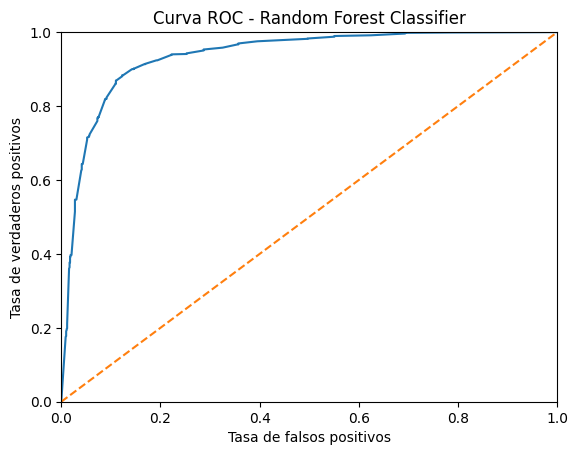

In [267]:
m_rfc=rfc(n_estimators=24,max_depth=21,random_state=21042407)
m_rfc.fit(f_train,t_train)
probab=m_rfc.predict_proba(f_test)
proba_1=probab[:,1]
ras_m_rfc=ras(t_test,proba_1)
print(f"Para los hiperparámetros seleccionados")
print(f"El valor auc_roc_score es de {ras_m_rfc:.2}")
predict=m_rfc.predict(f_test)
acs_m_rfc=acs(t_test,predict)
print(f"El valor de accuracy_score es de {acs_m_rfc:.2}")
fpr,tpr,thresholds=roc(t_test,proba_1)
plt.figure()
plt.plot(fpr,tpr,linestyle='-')
plt.plot([0,1],[0,1],linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title(f"Curva ROC - Random Forest Classifier")

### 8.3 Utilización del Modelo Seleccionado

Con las observaciones no consideradas debido a que son clientes nuevos, se utilizará el modelo seleccionado para predecir si el cliente nuevo terminará o no su contrato. Para esto, haremos las transformaciones y uniones necesarias, para definir las características y poder realizar la predicción.

In [268]:
#Leemos los datos del dataframe original
contract_original=pd.read_csv('D:/Datos_Perfil/OneDrive - PETROLEOS MEXICANOS/EJMRL/TripleTen/17 - Proyecto Final/contract.csv')
contract_original['TotalCharges']=pd.to_numeric(contract_original['TotalCharges'],errors='coerce')

In [269]:
#Definimos los clientes nuevos
new_customer=contract_original[contract_original['TotalCharges'].isna()]
new_customer

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


In [270]:
#Transformamos los datos del dataframe
encoder=le()
cols=new_customer.columns[3:6]
for i in cols:
    new_val=pd.DataFrame(encoder.fit_transform(contract[i]))
    new_customer[i]=new_val
new_customer['MonthsWithService']=1
new_customer['TotalCharges']=new_customer['MonthlyCharges']
new_customer=new_customer.drop(['BeginDate','EndDate'],axis=1)
new_customer

C:\Users\555081\AppData\Local\Temp\ipykernel_11200\234876930.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_customer[i]=new_val
C:\Users\555081\AppData\Local\Temp\ipykernel_11200\234876930.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_customer[i]=new_val
C:\Users\555081\AppData\Local\Temp\ipykernel_11200\234876930.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MonthsWithService
488,4472-LVYGI,0,1,2,52.55,52.55,1
753,3115-CZMZD,0,1,2,20.25,20.25,1
936,5709-LVOEQ,0,0,3,80.85,80.85,1
1082,4367-NUYAO,0,0,0,25.75,25.75,1
1340,1371-DWPAZ,1,1,1,56.05,56.05,1
3331,7644-OMVMY,0,1,2,19.85,19.85,1
3826,3213-VVOLG,0,0,0,25.35,25.35,1
4380,2520-SGTTA,2,0,3,20.00,20.00,1
5218,2923-ARZLG,0,0,2,19.70,19.70,1
6670,4075-WKNIU,2,1,3,73.35,73.35,1


In [271]:
#Comenzamos con la unión de dataframes
df_test=new_customer.merge(internet,on='customerID',how='left')
df_test

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MonthsWithService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,"IntServ(0=DSL,1=FO)"
0,4472-LVYGI,0,1,2,52.55,52.55,1,1.0,0.0,1.0,1.0,1.0,0.0,0.0
1,3115-CZMZD,0,1,2,20.25,20.25,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5709-LVOEQ,0,0,3,80.85,80.85,1,1.0,1.0,1.0,0.0,1.0,1.0,0.0
3,4367-NUYAO,0,0,0,25.75,25.75,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1371-DWPAZ,1,1,1,56.05,56.05,1,1.0,1.0,1.0,1.0,1.0,0.0,0.0
5,7644-OMVMY,0,1,2,19.85,19.85,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3213-VVOLG,0,0,0,25.35,25.35,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2520-SGTTA,2,0,3,20.00,20.00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2923-ARZLG,0,0,2,19.70,19.70,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,4075-WKNIU,2,1,3,73.35,73.35,1,0.0,1.0,1.0,1.0,1.0,0.0,0.0


In [272]:
df_test=df_test.merge(personal,on='customerID',how='left')
df_test

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MonthsWithService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,"IntServ(0=DSL,1=FO)",SeniorCitizen,Partner,Dependents,"gender(0=F,1=M)"
0,4472-LVYGI,0,1,2,52.55,52.55,1,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0,1,1,0
1,3115-CZMZD,0,1,2,20.25,20.25,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,1
2,5709-LVOEQ,0,0,3,80.85,80.85,1,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0,1,1,0
3,4367-NUYAO,0,0,0,25.75,25.75,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,1
4,1371-DWPAZ,1,1,1,56.05,56.05,1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0,1,1,0
5,7644-OMVMY,0,1,2,19.85,19.85,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,1
6,3213-VVOLG,0,0,0,25.35,25.35,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,1
7,2520-SGTTA,2,0,3,20.00,20.00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0
8,2923-ARZLG,0,0,2,19.70,19.70,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,1
9,4075-WKNIU,2,1,3,73.35,73.35,1,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0,1,1,0


In [273]:
#Obtenemos el df final unido
df_test=df_test.merge(phone,on='customerID',how='left')
df_test

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MonthsWithService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,"IntServ(0=DSL,1=FO)",SeniorCitizen,Partner,Dependents,"gender(0=F,1=M)",MultipleLines
0,4472-LVYGI,0,1,2,52.55,52.55,1,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0,1,1,0,NaN
1,3115-CZMZD,0,1,2,20.25,20.25,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,1,0.0
2,5709-LVOEQ,0,0,3,80.85,80.85,1,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0,1,1,0,0.0
3,4367-NUYAO,0,0,0,25.75,25.75,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,1,1.0
4,1371-DWPAZ,1,1,1,56.05,56.05,1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0,1,1,0,NaN
5,7644-OMVMY,0,1,2,19.85,19.85,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,1,0.0
6,3213-VVOLG,0,0,0,25.35,25.35,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,1,1.0
7,2520-SGTTA,2,0,3,20.00,20.00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,0.0
8,2923-ARZLG,0,0,2,19.70,19.70,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,1,0.0
9,4075-WKNIU,2,1,3,73.35,73.35,1,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0,1,1,0,1.0


In [274]:
#Eliminamos la columa necesaria
df_test_feat=df_test.drop(['customerID'],axis=1)

In [275]:
#Tomamos las mismas consideraciones que para el entrenamiento
df_test_feat=df_test_feat.fillna(0)
df_test_feat

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MonthsWithService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,"IntServ(0=DSL,1=FO)",SeniorCitizen,Partner,Dependents,"gender(0=F,1=M)",MultipleLines
0,0,1,2,52.55,52.55,1,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0,1,1,0,0.0
1,0,1,2,20.25,20.25,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,1,0.0
2,0,0,3,80.85,80.85,1,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0,1,1,0,0.0
3,0,0,0,25.75,25.75,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,1.0
4,1,1,1,56.05,56.05,1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0,1,1,0,0.0
5,0,1,2,19.85,19.85,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,0.0
6,0,0,0,25.35,25.35,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,1.0
7,2,0,3,20.00,20.00,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,0,0.0
8,0,0,2,19.70,19.70,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,0.0
9,2,1,3,73.35,73.35,1,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0,1,1,0,1.0


In [276]:
#Obtenemos las predicciones con las características obtenidas
predict=m_rfc.predict(df_test_feat)
predict

array([1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0], dtype=int64)

In [277]:
#Definimos para las predicciones 1 que se terminará el contrato
pred=[]
for i in predict:
    if i > 0:
        p='Terminará'
    else:
        p='Se mantendrá'
    pred.append(p)

In [278]:
#Creamos el df para identificar a los potenciales clientes que terminarán el contrato
predictions=pd.DataFrame({'customerID':new_customer['customerID'],'Predicción':predict,'Contrato':pred})

### 8.4 Recomendaciones

Con base en el resultado anterior, se identifican aquellos contratos que potencialmente estarían cancelando su servicio. Por lo tanto, se recomienda enfocarse en ellos para las promociones u ofertas para mantenerlos.

In [279]:
predictions

,customerID,Predicción,Contrato
488,4472-LVYGI,1,Terminará
753,3115-CZMZD,0,Se mantendrá
936,5709-LVOEQ,1,Terminará
1082,4367-NUYAO,1,Terminará
1340,1371-DWPAZ,0,Se mantendrá
3331,7644-OMVMY,1,Terminará
3826,3213-VVOLG,1,Terminará
4380,2520-SGTTA,0,Se mantendrá
5218,2923-ARZLG,0,Se mantendrá
6670,4075-WKNIU,0,Se mantendrá
